In [2]:
library(ggplot2)
library(tidytext)
library(magrittr)
library(RColorBrewer)
library(dplyr)
library(optparse)
library(stringr)
library(tibble)
library(gridExtra)
library(patchwork)
library(hash)
library(readxl)

source("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/utils.R")
source("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/analysis/ML/ML_utils.R")

parser <- OptionParser()
parser <- add_option(parser, c("--datasets"), type="character",
                     default=NULL)
parser <- add_option(parser, c("--cancer_types"), type="character")
parser <- add_option(parser, c("--cell_number_filter"), type="integer")
# parser <- add_option(parser, c("--pie_chart"), action="store_true", default=F)
parser <- add_option(parser, c("--tss_fragment_filter"),
                     type="character", default="-1")
parser <- add_option(parser, c("--ML_model"), type="character", default="XGB")
parser <- add_option(parser, c("--top_features_to_plot"),
                     type="character", default="1")
parser <- add_option(parser, c("--top_features_to_plot_feat_imp"),
                     type="character", default=NULL)
parser <- add_option(parser, c("--tissues_to_consider"),
                     type="character", default="all")
parser <- add_option(parser, c("--annotation"), 
                     type="character", default="default_annotation")
parser <- add_option(parser, c("--seed_range"), default="42-42")
parser <- add_option(parser, c("--robustness_analysis"), action="store_true", 
                     default=F)
parser <- add_option(parser, c("--robustness_accumulated_feature_importance_barplot"), 
                     action="store_true", 
                     default=F)
parser <- add_option(parser, c("--feature_importance_method"), type="character")
parser <- add_option(parser, c("--skip_seeds_robustness"), default="")
parser <- add_option(parser, c("--folds_for_test_set"), type="character", 
                     default="1-10")
parser <- add_option(parser, c("--feat_imp_min_n_robustness"), type="integer")
parser <- add_option(parser, c("--plot_fold_on_test_set_plot"), action="store_true", 
                     default=F)
parser <- add_option(parser, c("--hundred_kb"), action="store_true", default=F)
parser <- add_option(parser, c("--per_donor"), action="store_true", default=F)
parser <- add_option(parser, c("--grid_analysis"), action="store_true", default=F)
parser <- add_option(parser, c("--grid_cell_types"), type="character")
parser <- add_option(parser, c("--cell_types_keep"), type="character", 
                     default=NULL)
parser <- add_option(parser, c("--subsampled_mutations"), action="store_true",
                     default=F)
parser <- add_option(parser, c("--robustness_keep"), type="character", 
                     default=NULL)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


hash-2.2.6.3 provided by Decision Patterns




In [5]:
args = parse_args(parser, args= c("--cancer_types=CNS-Medullo,Liver-HCC,CNS-GBM,Skin-Melanoma",
                                  "--cell_number_filter=100",
                                  "--datasets=Bingren,Bingren_adult_brain,Greenleaf_brain,Shendure-Bingren,Greenleaf_colon,Greenleaf_pbmc_bm,Shendure,Tsankov,Yang_kidney-Bingren,Bingren_adult_brain,Greenleaf_brain,Shendure-Bingren,Greenleaf_colon,Greenleaf_pbmc_bm,Shendure,Tsankov,Yang_kidney",
                                  "--tissues_to_consider=adult_brain,brain,frontal_cortex,cerebrum,cerebellum-all-adult_brain,frontal_cortex,cerebrum,brain,cerebellum-all",
                                  "--ML_model=XGB",
                                  "--seed_range=1-10",
                                  "--feat_imp_min_n_robustness=50",
                                  "--folds_for_test_set=1-10",
                                  "--feature_importance_method=permutation_importance",
                                  "--folds_for_test_set=1-10",
                                  "--robustness_analysis",
                                  "--subsampled_mutations",
                                  "--annotation=finalized_annotation",
                                  "--top_features_to_plot=1"))

# args = parse_args(parser)

cancer_names = hash("Skin-Melanoma"="Melanoma",
                    "Liver-HCC"="Liver cancer",
                    "ColoRect-AdenoCA"="Colorectal cancer",
                    "Eso-AdenoCa"="Esophageal cancer",
                    "CNS-GBM"="Glioblastoma",
                    "Lung-AdenoCA"="Lung adenocarcinoma",
                    "Lung-SCC"="Lung squamous cell carcinoma",
                    "Breast-AdenoCa"="Breast adenocarcinoma",
                    "Lymph-CLL"="Lymphocytic leukemia",
                    "Lymph-BNHL"="Non-Hodgkin lymphoma",
                    "multiple_myeloma"="Multiple Myeloma",
                    "Myeloid-AML"="Acute myeloid leukemia",
                    "Bone-Leiomyo"="Leiomyosarcoma",
                    "Thy-AdenoCA"="Thyroid adenocarcinoma",
                    "Uterus-AdenoCA" = "Uterus adenocarcinoma")


cell_types = c("brain OPC/Oligo GL_Br" = "OPC/Oligo, Cerebral Cortex GL_Br",
               "cerebrum Astrocytes/Oligodendrocytes SH" = "Astrocytes/Oligo, Cerebrum SH",
               "colon_transverse Macrophage (General) BR" = "Macrophage, Transverse Colon BR",
               "colon_transverse Small Intestinal Enterocyte BR" = "Enterocyte, Transverse Colon BR",
               "colon_transverse Plasma Cell BR" = "Plasma Cell, Transverse Colon BR",
               "colon_transverse T Lymphocyte (CD8+) BR" = "T Lymphocyte, Transverse Colon BR",
               "heart_atrial_appendage Cardiac Pericyte BR" = "Pericyte, Atrial Appendage BR",
          		 "lung Ciliated epithelial cells SH"="Ciliated, Lung SH",
               "lung Tuft.like TS" = "Tuft-like, Lung TS",
               "lung Bronchiolar and alveolar epithelial cells SH" = "Bronchiolar/alveolar, Lung SH",
               "lung proximal Ciliated TS" = "Ciliated, Proximal Lung TS",
               "lung B.cells TS" = "B, Lung TS",
          		 "lung SmoothMuscle TS" = "Smooth Muscle, Lung TS",
          		 "muscle Type II Skeletal Myocyte BR" = "Skeletal Myocyte, Muscle Type II BR",
          		 "nerve_tibial Fibroblast (Peripheral Nerve) BR" = "Fibroblast Tibial Nerve BR",
               "nerve_tibial Schwann Cell (General) BR" = "Schwann Cell, Tibial Nerve BR",
          		 "pancreas Pancreatic Alpha Cell BR" = "Alpha Cell, Pancreas BR",
          		 "pancreas Pancreatic Acinar Cell BR" = "Acinar, Pancreas BR")

ggplot_barplot_helper <- function(df, title, savepath, y, ylab, 
                                  accumulated_imp=F) {
  df$num_features_f = factor(df$num_features, levels=unique(df$num_features))
  colors = get_n_colors(20, 1)
  
  from = as.character(unique(df$num_features))
  to = paste(levels(df$num_features_f), "features", sep=" ")
  if (!accumulated_imp) {
    to = paste(to, paste("(R^2=", 
                         as.character(round(unique(df$score*100), 1)), ")",
                         sep=""))
  }
  names(to) <- from
  plot = ggplot(df, aes(x=reorder_within(features, -!!sym(y), within=num_features_f,
                                         sep="."), 
                        y=!!sym(y), fill=features)) +
    facet_wrap(~num_features_f, nrow=1, 
               labeller = as_labeller(to), scales = "free") +
    geom_bar(stat="identity", width=1, color="white") +
    xlab("Cell type") +
    ylab(ylab) +
    theme(axis.text.x = element_text(angle=90, vjust = 0.5, hjust=1,
                                     size=15)) +
    guides(fill="none") +
    scale_fill_manual(values=colors) +
    ggtitle(title) +
    theme(plot.title = element_text(hjust = 0.5))
  ggsave(paste(savepath, paste(y, "bar_plot.png", sep="_"), sep="/"), 
         width = 20, height = 15, plot, limitsize=F)
}

construct_bar_plots <- function(cancer_type, 
                                datasets,
                                cell_number_filter,
                                tss_fragment_filter,
                                annotation,
                                ML_model,
                                seed,
                                accumulated_seeds,
                                feature_importance_method, 
                                fold_for_test_set,
                                hundred_kb, 
                                per_donor,
                                n_filter=NULL) {
  dirs = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
                                          datasets=datasets,
                                          cell_number_filter=cell_number_filter,
                                          tss_fragment_filter=tss_fragment_filter,
                                          annotation=annotation,
                                          ML_model=ML_model,
                                          hundred_kb=hundred_kb,
                                          fold_for_test_set=fold_for_test_set,
                                          seed=seed,
                                          accumulated_seeds=accumulated_seeds,
                                          per_donor=per_donor)
  
  if (per_donor) {
    counts=data.frame()
  }
  for (dir in dirs) {
    file = paste(dir, "df_for_feature_importance_plots", sep="/")
    if (feature_importance_method != "default_importance") {
      file = paste(file, feature_importance_method, sep="_")
    }
    file = paste(file, "csv", sep=".") 
    file = paste("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures", file, sep="/")
    df = as_tibble(read.csv(file))
    title = unlist(strsplit(dir, split ="/"))
    title = title[length(title) - 2]
    df = df[df$num_features %in% top_features_to_plot, ]
    if (per_donor) {
      df["donor"] = unlist(strsplit(title, split = "_"))[2]
      counts = rbind(counts, df)
    } else {
      ggplot_barplot_helper(df, title, savepath=paste("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures", dir, sep="/"), 
                          ylab=gsub("_", " ", feature_importance_method), 
                          y=feature_importance_method)
    }
  }
  
  if (per_donor) {
    dir = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
                                            datasets=datasets,
                                            cell_number_filter=cell_number_filter,
                                            tss_fragment_filter=tss_fragment_filter,
                                            annotation=annotation,
                                            ML_model=ML_model,
                                            hundred_kb=hundred_kb,
                                            fold_for_test_set=fold_for_test_set,
                                            seed=seed,
                                            accumulated_seeds=F,
                                            per_donor=F)
    fp = paste(dir, "per_donor_predictions.csv", sep="/")
    write.csv(counts, fp)
    bin_width = 0.05
    break_points <- seq(min(counts$score), max(counts$score) + bin_width, bin_width)
    labels <- sprintf("%.2f-%.2f", head(break_points, -1), tail(break_points, -1))
    if (!is.null(n_filter)) {
      dist = table(counts[["features"]])
      keep = names(dist)[dist >= n_filter]
      counts = counts %>% filter(features %in% keep)
    }
    df <- counts %>%
            mutate(bin = cut(score, breaks = break_points,labels=labels,
                             right = FALSE)) %>%
            group_by(bin, features) %>%
            summarise(count = n()) %>%
            arrange(desc(count))
    
    total_counts <- df %>%
                      group_by(features) %>%
                      summarise(total = sum(count)) %>%
                      arrange(desc(total))
    df = df %>% 
          left_join(total_counts) %>%
          mutate(features = paste0(features, " (n=", total, ")")) 
    ggplot(df, aes(x = bin, y = count, fill = features)) +
      geom_bar(stat = "identity", position = "stack") +
      geom_text(aes(label = count), position = position_stack(vjust = 0.5),
                size = 3) +
      labs(title = paste(cancer_type, "per donor"), x = "Validation R^2", 
           y = "Count") +
      scale_x_discrete(limits = levels(df$bin)) +
      theme(axis.text.x = element_text(size=6))
    
    # ggplot(counts, aes(x = score, fill = features)) +
    #   geom_histogram(position = "stack", bins = 10) +
    #   labs(title = paste(cancer_type, "per donor"), x = "Validation R^2", y = "Count")
  }
}

rename_cell_types <- function(cell_type_names) {
  renamed = strsplit(cell_type_names, split=" ")
  tissue = lapply(renamed, "[", 1)
  dataset = lapply(renamed, function(x) x[length(x)])
  cell_type = lapply(renamed, function(x) paste(x[2:(length(x)-1)], 
                                                  collapse=" "))
  cell_type = gsub("_", " ", cell_type)
  tissue = gsub("_", " ", tissue)
  renamed = paste(paste0(cell_type, ","), tissue)
  
  idx = !((substring(renamed, 1, 1) == tolower(substring(renamed, 1, 1))
          & substring(renamed, 2, 2) == toupper(substring(renamed, 2, 2))) |
            grepl("GluN", renamed) | grepl("\\/", renamed))
  
  to_custom_title <- function(input_string) {
    words <- str_split(input_string, "\\s+")[[1]]
    custom_title_case <- function(word) {
      if (toupper(word) != word) {
        return(str_to_title(word))
      } else {
        return(word)
      }
    }
    title_cased_words <- sapply(words, custom_title_case)
    return(paste(title_cased_words, collapse = " "))
  }
  renamed[idx] = unlist(lapply(renamed[idx], to_custom_title))
  
  renamed = paste(renamed, dataset)
  renamed = ifelse(cell_type_names %in% names(cell_types), 
                     unname(cell_types[cell_type_names]), 
                   renamed)

  idx <- lapply(renamed, function(x) {
    matches_colon_gl_co <- grep("Colon GL_Co", x)
    non_matches_specific <- grep("Normal Colon GL_Co|Polyp Colon GL_Co", x, invert = TRUE)
    
    intersect(matches_colon_gl_co, non_matches_specific)
  })
  idx <- which(sapply(idx, length) > 0)
  renamed[idx] = gsub("Colon GL_Co", "Normal Colon GL_Co", renamed[idx])
  renamed = gsub("brain GL_Br", "Cerebral Cortex GL_Br", renamed, 
                 ignore.case = T)
  renamed = gsub("GluN", "Glutamatergic Neuron", renamed)
  renamed = gsub("\\s+\\(.*\\)", "", renamed)
  renamed = gsub("Gmp.neut", "GMP.Neut", renamed)
  # renamed = gsub("brain GluN GL_Br", "Cerebral Cortex GL_Br", renamed)
  return(renamed)
}

construct_robustness_boxplots <- function(df, x, y, title, savepath, savefile,
                                          facet_var, xlabel="", plot_fold=F, 
                                          n_name=NULL, width=12, height=8,
                                          keep=NULL) {
  #df = df_feat_imp
  lwd = 3
  str_wrap_width = 15
  outlier_size = 20
  text_size = 60
  axis_lwd = 0.5
  tick_length = 1
  title_size = 150
  axis_text_size = 150
  axis_tick_size = 5
  print(length(unique(df[[facet_var]])) == 1)
  #if (length(unique(df[[facet_var]]) == 1)) {
  #  print(unique(df[[facet_var]]))
  #  print('a')
  #  outlier_size = 10
  #  text_size = 10
  #  axis_lwd = 0.1
  #  tick_length = 0.1
  #  title_size = 150
  #  axis_text_size = 40
  #  axis_tick_size = 1
  #  width = 12
  #  height = 8
  #}
  
  renamed_y = rename_cell_types(df %>% pull(!!sym(y)))
  
  if (!(savefile == "temp.pdf")) {
    df = df %>%
      ungroup() %>%
      mutate("{y}" := renamed_y)
      # mutate("{y}" := unname(cell_types[df %>% pull(!!sym(y))]))
  }
  
  # df[y] = str_wrap(df[[y]], width=15)

  if (plot_fold) {
    outlier_shape = NA
  } else {
    outlier_shape = 19
  }
  
  plots <- list()

  for (level in unique(df[[facet_var]])) {
    df_filtered <- df %>% 
                     filter(!!sym(facet_var) == level)
    
    if (x == "permutation_importance") {
      unique_combos = unique(df_filtered[, c("features", "n_feature", "med_imp")])
        sorted_features = unique_combos %>% 
        arrange(desc(n_feature), desc(med_imp)) %>%
        pull(features)
      df_filtered = df_filtered %>% 
          filter(features %in% unique(sorted_features)[1:5] | features %in% 
                   keep)
    }
    df_filtered[y] = str_wrap(df_filtered[[y]], width=str_wrap_width)
    
    # print(unique(df %>% pull(!!sym(y))))
    # 
    df_compressed = df_filtered %>%
                      group_by(!!sym(y)) %>%
                      summarise(med_x = median(!!sym(x)))
    df_filtered = df_filtered %>% 
                    left_join(df_compressed) %>%
                    arrange(!!sym(n_name), med_x)
    top = unique(df_filtered %>% pull(!!sym(y)))
    top = top[length(top)]
    
    df_filtered = df_filtered %>% 
                    ungroup() %>%
                    mutate(color=ifelse(!!sym(y)==top, "highlight", "other"))
    
    # ifelse(!!sym(n_name)==max(!!sym(n_name)) &
    #          med_x==max(med_x), "highlight", 
    #        "other")
    
    ordered_levels <- df_filtered %>% pull(!!sym(y)) %>% unique()
    df_filtered <- df_filtered %>% 
                      mutate(y_reordered = factor(!!sym(y), 
                                                  levels = ordered_levels))
    xlim_lower = min(df_filtered[[x]])
    xlim_upper = max(df_filtered[[x]])
    color = rep("#000000", length(unique(df_filtered[[y]])) - 1)
    color = append(color, "#EE4B2B")
    if (level == "1") {
    	subtitle = paste(level, "feature")
    } else {
    	subtitle = paste(level, "features")
    }
    
    # df_filtered["wrapped_y"] = str_wrap(df_filtered$y_reordered, width=15)
    p <- ggplot(df_filtered) +
            geom_boxplot(aes(x = !!sym(x), y_reordered, fill=color), lwd = lwd, 
                             outlier.shape = outlier_shape, outlier.size=outlier_size) +
            geom_text(aes(x = x_position + x_position / 30,
                          y = y_reordered),
                          label = paste0("n=", df_filtered[[n_name]]),
			  size=text_size) +
            # ggtitle(subtitle) +
            scale_fill_manual(values = c("highlight" = "#EE4B2B",
                                         "other" = "#A9A9A9")) +
            theme_classic() +
            theme(
                legend.position="none",
                strip.background = element_blank(),
                strip.text.x = element_blank(),
                plot.title = element_text(hjust = 2, size=title_size),
                axis.text.y = element_text(size = axis_text_size, colour = color),
                axis.text.x = element_text(size = axis_text_size),
                axis.title.x=element_blank(),
                axis.title.y=element_blank(),
                axis.ticks = element_line(size=axis_tick_size),
                axis.ticks.length = unit(tick_length, "cm"),
                axis.line = element_line(linewidth=axis_lwd)
              ) +
            xlim(xlim_lower - xlim_lower / 10, xlim_upper + 2 * xlim_upper / 10)
    plots[[as.character(level)]] <- p
  }
  
  if (length(plots) > 1) {
    plot <- wrap_plots(plots, ncol=length(unique(df[[facet_var]])), 
                                nrow=1)
    plot <- plot + 
              plot_layout(guides = 'collect')
      # plot_annotation(caption = xlabel)
      # plot_annotation(title = title) +
      
  } else {
    plot <- plots[[1]] #+
              #theme(axis.title.x=element_text(size=15),
                    #axis.text.x = element_text(size=12))
    # xlab(xlabel)
  }

  if (plot_fold) {
    plot = plot + 
      geom_point(aes(x = reorder_within(x=!!sym(x), 
                                      by=!!sym(y), 
                                      within=!!sym(facet_var), 
                                      median), 
                   y = !!sym(y), 
                   fill=fold,
                   alpha=scale(scatac_counts),
                   size=scale(mut_counts)), pch=21, stroke=NA) +
      scale_fill_manual(values = c("#800000", "#808000",
                                   "#469990", "#000000",
                                   "#e6194B", "#ffe119",
                                   "#3cb44b", "#4363d8",
                                   "#f032e6", "#a9a9a9",
                                   "#ffd8b1", "#aaffc3"))
  }
  plot
  # print(plot)
  ggsave(paste(savepath, savefile, sep="/"), 
         width = width * length(unique(df[[facet_var]])), 
         height = height, plot, limitsize=F)
}

construct_top_feat_barplot <- function(df_test, savefile, savepath, 
                                       width=12, height=7) {
  df = df_test
  if (!(savefile == "temp_test.pdf")) {
    df = df %>%
      mutate(top_feature = rename_cell_types(df %>% pull(top_feature)))
  }
  
  df["top_feature"] = str_wrap(df[["top_feature"]], width=15)
  
  df = df %>% 
          filter(top_n == 1) %>%
          select(top_feature, n_top_feature) %>%
          unique() %>%
          arrange(desc(n_top_feature))
  # y = factor(top_feature,
  #            levels=rev(c("mammary_tissue-Basal-Epithelial-(Mammary)-BR",
  #                         "bonemarrow-B-GL_BlBm",
  #                         "bonemarrow-Early.Baso-GL_BlBm",
  #                         "stomach-Stromal-cells-SH",
  #                         "thyroid-Thyroid-Follicular-Cell-BR"
  #            ))
  df = df %>% 
        mutate(color=ifelse(n_top_feature == max(n_top_feature), 
                            "highlight","other"))
  color = rep("#000000", nrow(df) - 1)
  color = append(color, "#EE4B2B")
  num_appearances = df[["n_top_feature"]]
  p <- ggplot(df) +
    geom_col(aes(x = n_top_feature, y = factor(top_feature,
                                               levels=rev(df[["top_feature"]])),
                 fill=color), lwd=1.2) +
    geom_text(aes(x = n_top_feature + 7,
                  y = top_feature),
              label = paste0("n=", num_appearances), size=40) +
    scale_fill_manual(values = c("highlight" = "#EE4B2B", "other" = "#A9A9A9")) +
    ylab("") +
    xlab("") +
    # xlab("top feature across 100 runs") +
    theme_bw() +
    xlim(0, max(df[["n_top_feature"]]) + 8) +
    theme(
      legend.position="none",
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      # plot.title = element_text(hjust = 0.5, size = 40),
      axis.text.x = element_text(vjust = 0.5, hjust=1, size=150),
      axis.text.y = element_text(size=150, colour = color),
      axis.title = element_text(size=150),
      panel.grid.major.y=element_blank(),
      panel.grid.minor.x=element_blank(),
      axis.ticks = element_line(size=7),
      axis.ticks.length = unit(1, "cm"),
      panel.grid.major.x = element_line(size = 1)
      # plot.margin = margin(t=0,r=1,b=0,l=0, unit = "cm")
    ) 
  print(p)
  ggsave(paste(savepath, savefile, sep="/"), 
         width = width, height = height, limitsize = FALSE)
}

construct_robustness_barplots <- function(df, x, y, title, add_to_pos) {
  df[x] = 100 * df[x]
  df = df %>% 
        group_by(!!sym(y)) %>%
        summarise(mean_se(test_set_perf)) %>%
        mutate(color=ifelse(y == max(y), "highlight","other"))
  
  xlim_lower = min(df[["ymin"]])
  xlim_upper = max(df[["ymax"]])
  x_breaks <- pretty(df$y, n = 3)
  plot <- ggplot(df) +
    # geom_col(aes(x = y, y = factor(top_feature,
    #                                 levels=rev(c("skin_sun_exposed-Melanocyte-BR",
    #                                             "liver-Hepatoblasts-SH",
    #                                             "normal_colon-Stem-GL_Co",
    #                                             "bonemarrow-B-GL_BlBm",
    #                                             "stomach-Goblet-cells-SH",
    #                                             "cerebrum-Astrocytes-Oligodendrocytes-SH",
    #                                             "lung-AT2-TS",
    #                                             "lung-Basal-TS"
    #                                             ))),
    #geom_col(aes(x = y, y = factor(top_feature,
    #                               levels=rev(c("mammary_tissue-Basal-Epithelial-(Mammary)-BR",
    #                                            "bonemarrow-B-GL_BlBm",
    #                                            "bonemarrow-Early.Baso-GL_BlBm",
    #                                            "stomach-Stromal-cells-SH",
    #                                            "thyroid-Thyroid-Follicular-Cell-BR",
    #                                            "placenta-PAEP_MECOM-positive-cells-SH"
    #                               ))),
    geom_col(aes(x = y, y = factor(top_feature,
                                levels=rev(c("bonemarrow-B-GL_BlBm",
                                             # "bonemarrow-Early.Baso-GL_BlBm",
                                             "stomach-Stromal-cells-SH",
                                             "thyroid-Thyroid-Follicular-Cell-BR",
                                             "placenta-PAEP_MECOM-positive-cells-SH"
                                ))),
    # geom_col(aes(x = y, y = factor(top_feature,
    #                                levels=rev(c("mammary_tissue-Basal-Epithelial-(Mammary)-BR",
    #                                             "bonemarrow-B-GL_BlBm",
    #                                             "bonemarrow-Early.Baso-GL_BlBm",
    #                                             "stomach-Stromal-cells-SH",
    #                                             "thyroid-Thyroid-Follicular-Cell-BR",
    #                                             "placenta-PAEP_MECOM-positive-cells-SH"
    #                                ))),
                 fill=color), lwd=1.2) +
    geom_errorbarh(aes(y = top_feature, xmin = ymin, xmax = ymax), linewidth=2) +  
    coord_cartesian(xlim = c(xlim_lower, xlim_upper)) +
    scale_fill_manual(values = c("highlight" = "#EE4B2B", "other" = "#A9A9A9")) +
    ylab("") +
    ggtitle(title) +
    scale_x_continuous(breaks = x_breaks) +   
    theme_bw() +
    theme(
      legend.position="none",
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      plot.title = element_text(hjust = 0.5, size = 40),
      axis.text.x = element_text(vjust = 0.5, hjust=1, size=40),
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      axis.title.x=element_blank(),
      panel.grid.major.y=element_blank(),
      panel.grid.minor.x=element_blank(),
      panel.grid.major.x = element_line(size = 1),
      plot.margin = margin(t=0,r=1,b=0,l=0, unit = "cm")
    ) 
  return(plot)
}

save_perf_to_file <- function(df_save, feature, cancer_type, 
                              perf, perf_savefile) {
  if (feature %in% rownames(df_save) && cancer_type %in% colnames(df_save)) {
    print("OVERWRITING PREVIOUS RESULT")
  }
  df_save[feature, cancer_type] = perf
  write.csv(df_save, perf_savefile)
}


construct_test_set_perf_boxplots <- function(df, feature, savefile, savepath, 
                                             df_perf, perf_savefile, cancer_type, 
                                             width=9, height=7) {
  df["test_set_perf"] = 100 * df[["test_set_perf"]]
  feature = rename_cell_types(feature)
  outlier_shape = 19
  n_top_feature = unique(df %>% select(top_n, n_top_feature)) %>%
                         arrange(desc(top_n))
  # a = n_top_feature[["n_top_feature"]]
  df$top_n = factor(df$top_n)
  df$top_n = factor(df$top_n, levels = rev(levels(df$top_n)))
  df$x_position = 100 * df$x_position
  # ggplot2 plot
  save_perf_to_file(df_perf, feature=feature, 
                    cancer_type=cancer_type,
                    perf = median(df[["test_set_perf"]]),
                    perf_savefile=perf_savefile)

  ggplot(df) +
    geom_boxplot(aes(x = top_n, y = test_set_perf), lwd = 2, 
                 outlier.shape = outlier_shape, outlier.size = 30) +
    scale_x_discrete(limits = levels(df$top_n)) +
    geom_text(aes(x = top_n,
                    y = x_position + x_position / 30),
                label = paste0("n=", df[["n_top_feature"]]), 
              size=40) +
    ggtitle(feature) +
    # theme_bw() +
    theme(
      # legend.position="none",
      # strip.background = element_blank(),
      strip.text.x = element_blank(),
      plot.title = element_text(hjust = 0.5, size=150),
      axis.text.y = element_text(size = 150),
      axis.text.x = element_text(size = 150),
      axis.title.x=element_blank(),
      axis.title.y=element_blank(),
      axis.ticks = element_line(size=30),
      # axis.ticks.length = unit(1, "cm"),
      axis.line = element_line(linewidth=1)
    )
  
    ggsave(paste(savepath, savefile, sep="/"), 
         width = width, 
         height = height,
	 limitsize=F)
}

construct_df_feature_importances_all_seeds <- function(all_seeds_dirs,
                                                       feature_importance_method) {
  df_feature_importances_all_seeds = tibble()
  for (dir in all_seeds_dirs) {
    tryCatch(
      {
        df_feature_importance_path = paste(dir, "backwards_elimination_results", 
                                           "df_for_feature_importance_plots",
                                           sep="/")
        if (feature_importance_method != "default_importance") {
          df_feature_importance_path = paste(df_feature_importance_path,
                                             feature_importance_method,
                                             sep = "_")
        }
        df_feature_importance_path = paste(df_feature_importance_path, 
                                           "csv",
                                           sep=".")
        df_feature_importances = as_tibble(read.csv(df_feature_importance_path))
        # df_feature_importances = df_feature_importances %>%
        #   filter(num_features %in% top_features_to_plot)
        seed = str_extract(dir, pattern="seed_[0-9]*")
        seed = unlist(strsplit(seed, split="_"))
        seed = seed[length(seed)]
        fold_for_test_set = str_extract(dir, pattern="fold_for_test_set_[0-9]*")
        fold_for_test_set = unlist(strsplit(fold_for_test_set, split="_"))
        fold_for_test_set = fold_for_test_set[length(fold_for_test_set)]
        df_feature_importances["seed"] = seed
        df_feature_importances["fold_for_test_set"] = fold_for_test_set

        if (nrow(df_feature_importances_all_seeds) == 0) {
          df_feature_importances_all_seeds = df_feature_importances
        } else {
          df_feature_importances_all_seeds = rbind(df_feature_importances_all_seeds,
                                                   df_feature_importances)
        }
      },
      error = function(e) {
        print(paste("Problem with", dir))
      }
    )
  }
  return(df_feature_importances_all_seeds)
}

# plot_accumulated_feature_importance <- function(df_feature_importances_all_seeds,
#                                                 savepath,
#                                                 cancer_type) {
#   df_accumulated_imp = df_feature_importances_all_seeds %>% 
#     group_by(features, num_features) %>%
#     summarise(sum(importance))
#   colnames(df_accumulated_imp)[3] = "importance"
#   dir.create(savepath, recursive = T)
#   
#   ggplot_barplot_helper(df=df_accumulated_imp, 
#                         title=cancer_type, 
#                         savepath=savepath,
#                         accumulated_imp=T)
# }

get_top_feat_at_idx <- function(test_file_idx, idx, feature_importance_method,
                                test_dir, fold, seed) {
  top_feature_file = paste0("top_features_iteration_",
                            test_file_idx[idx])
  
  if (feature_importance_method != "default_importance") {
    top_feature_file = paste(top_feature_file,
                             "by", 
                             feature_importance_method, 
                             sep = "_")
  }
  
  top_feature_file = paste0(top_feature_file, ".txt")
  top_feature_fp = paste(test_dir, top_feature_file, sep="/")
  tryCatch(
    { top_feature = readLines(top_feature_fp, n = 1)
    }, 
    error = function(e) {
      print(paste("Problem with fold", fold, ", seed", seed))
    }
  )
  top_feature = substring(top_feature, 4, nchar(top_feature))
  return(top_feature)
}

construct_all_seeds_test_df <- function(top_features_to_plot,
                                        seed_range,
                                        skip_seeds_robustness,
                                        cancer_type,
                                        datasets,
                                        cell_number_filter,
                                        tss_fragment_filter, 
                                        annotation,
                                        tissues_to_consider,
                                        ML_model,
                                        folds_for_test_set,
                                        feature_importance_method,
                                        hundred_kb, 
                                        grid_analysis=F,
                                        grid_cell_type=NULL,
                                        cell_types_keep=NULL,
                                        manually_supplied_dirs=NULL) {
  patient_counts = read_excel("../../paper/supplementary_files/Supplementary_File_S1.xlsx")
  add_test_perf_to_df <- function(df, test_dir, feature_importance_method, 
                                  grid_analysis, top_features_to_plot, 
                                  grid_cell_type, fold, seed) {
    if (feature_importance_method != "default_importance") {
      model_pattern = paste("^top_features_iteration_[0-9]+_by",
                            feature_importance_method, sep="_")
      model_pattern = paste(model_pattern, "txt", sep=".")
    } else {
      model_pattern = "^top_features_iteration_[0-9]+\\.txt"
    }
    total_num_features = list.files(test_dir, pattern=model_pattern)
    total_num_features = length(total_num_features) + 1
    
    # #### TEMP ####
    # total_num_features=20
    # ###############
    # sort so that later the first test_file_idx can be checked for 
    # total_num_features == test_file_idx
    
    test_file_idx = sort(total_num_features - top_features_to_plot + 1)
    test_perf_filenames = paste("model_iteration", test_file_idx,
                                sep = "_")
    if (feature_importance_method != "default_importance") {
      test_perf_filenames = paste(test_perf_filenames,
                                  "feature_importance", 
                                  feature_importance_method, 
                                  sep = "_")
    }
    test_perf_filenames = paste(test_perf_filenames, 
                                "test_performance.txt", sep="_")
    test_set_perf_files = paste(test_dir, test_perf_filenames, sep="/")
    
    idx = 1
    
    for (file in test_set_perf_files) {
      # if (!(idx == length(test_set_perf_files) &&
      #       test_file_idx[length(test_file_idx)] == total_num_features)) {
      if (!grid_analysis) {
        if (test_file_idx[length(test_file_idx)] != total_num_features) {
          top_feature = get_top_feat_at_idx(test_file_idx = test_file_idx,
                                            idx=idx,
                                            feature_importance_method = 
                                              feature_importance_method,
                                            test_dir = test_dir,
                                            fold=fold, seed=seed)
        } else {
          top_feature = get_top_feat_at_idx(test_file_idx = test_file_idx - 1,
                                            idx=idx,
                                            feature_importance_method = 
                                              feature_importance_method,
                                            test_dir = test_dir,
                                            fold=fold, seed=seed)
        }
      } else {
        top_feature = grid_cell_type
      }
      suppressWarnings({
        tryCatch(
          { perf = read.table(file, header=F)[1,1]
          },
          error = function(e) {
            print(paste("Problem with test perf fold", 
                        fold, ", seed", seed))
          }    
        )})
      # if (grid_analysis) {
      #   top_feature = grid_cell_type
      # }
      num_samples = unlist(strsplit(test_dir, split="/"))[3]
      num_samples = as.integer(str_extract(num_samples, "[0-9]+"))
      if (is.na(num_samples)) {
        num_samples = patient_counts[patient_counts[["Cancer type"]] == 
                                       cancer_type[length(cancer_type)], 
                                     "Number of donors"] %>% pull()
      }
      df = df %>% add_row(top_feature = top_feature,
                          top_n = top_features_to_plot[idx],
                          test_set_perf = perf,
                          seed = seed, 
                          fold = fold,
                          num_samples=num_samples)
      idx = idx + 1
    }
    return(df)
  }
  

  top_features_to_plot = sort(top_features_to_plot, decreasing = T)
  if (is.null(manually_supplied_dirs)) {
    df = tibble(top_feature = character(0),
                top_n = integer(0),
                test_set_perf = double(0),
                seed = integer(0),
                fold = integer(0),
                num_samples = integer(0))
    for (seed in seed_range) {
      for (fold in folds_for_test_set) {
        if (!(seed %in% skip_seeds_robustness)) {
          test_dir = construct_backwards_elim_dir(cancer_type,
                                                  construct_sources_string(datasets),
                                                  cell_number_filter,
                                                  tss_fragment_filter, 
                                                  annotation,
                                                  tissues_to_consider,
                                                  ML_model,
                                                  seed,
                                                  fold_for_test_set = fold,
                                                  hundred_kb = hundred_kb,
                                                  grid_analysis=grid_analysis,
                                                  grid_cell_type=grid_cell_type,
                                                  cell_types_keep=cell_types_keep)
          for (dir in test_dir) {
            df = add_test_perf_to_df(df, dir, feature_importance_method,
                                     grid_analysis, top_features_to_plot,
                                     grid_cell_type, fold, seed)
          }
        }
      }
    }
  } else {
    df = tibble(top_feature = character(0),
                top_n = integer(0),
                test_set_perf = double(0),
                seed = integer(0),
                fold = integer(0),
                num_samples=integer(0))
    manually_supplied_dirs = gsub("../../figures/", "", manually_supplied_dirs)
    manually_supplied_dirs = paste(manually_supplied_dirs, 
                                   "backwards_elimination_results", sep="/")
    for (test_dir in manually_supplied_dirs) {
      split = unlist(strsplit(test_dir, split="/"))
      seed = str_extract(split[4], "seed_[0-9]+")
      seed = unlist(strsplit(seed, split="_"))[2]
      fold = str_extract(split[4], "fold_for_test_set_[0-9]+")
      fold = unlist(strsplit(fold, split="_"))[5]
      df = add_test_perf_to_df(df, test_dir, feature_importance_method,
                               grid_analysis, top_features_to_plot,
                               grid_cell_type, as.integer(fold), 
                               as.integer(seed))
    }
  }
  df["fold"] = as.factor(df[["fold"]])
  return(df)
}

plot_dist <- function(X, bin_names) {
  df <- data.frame(index = 1:nrow(X), 
                   value = X)
  use_names = seq(1, length(df$index), by=10)
  use_names = append(use_names, nrow(X))
  p = ggplot(df) +
    geom_bar(aes(x=index, y=value),
             stat="identity") +
    xlab("Bin") +
    ylab("Counts") +
    geom_text(x=nrow(df) / 2, y=max(df[["value"]]), 
              aes(label=paste0("n=", sum(df[["value"]]))),
              size=10) +
    scale_x_continuous(name="Row Names", breaks=df$index[use_names], 
                       labels=bin_names[use_names]) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  return(p)
}


get_and_plot_scatac_and_mutation_counts_per_fold <- function(cancer_type,
                                                    folds_for_test_set,
                                                    datasets,
                                                    cell_number_filter,
                                                    tss_fragment_filter,
                                                    annotation, 
                                                    ML_model,
                                                    hundred_kb,
                                                    tissues_to_consider) {
  scatac_counts_plots <- list()
  scatac_counts <- c()
  mut_counts_plots <- list()
  mut_counts <- c()
  for (fold in folds_for_test_set) {
    # for (tss_filter in tss_fragment_filter) {
    scATAC_sources = construct_sources_string(datasets)
    dir = construct_dir(scATAC_sources,
                        cell_number_filter,
                        tss_fragment_filter,
                        annotation,
                        1,
                        fold,
                        ML_model,
                        cancer_type,
                        hundred_kb,
                        tissues_to_consider)
    X_test = read.csv(paste(dir, "X_test.csv", sep="/"), row.names = 1,
                      check.names = FALSE)
    y_test = read.csv(paste(dir, "y_test.csv", sep="/"), row.names = 1)
    backwards_elim_dir = construct_backwards_elim_dir(cancer_type, 
                                                      scATAC_sources, 
                                                      cell_number_filter,
                                                      tss_fragment_filter, 
                                                      annotation,
                                                      tissues_to_consider,
                                                      ML_model,
                                                      1,
                                                      fold_for_test_set=fold,
                                                      hundred_kb = hundred_kb)
    if (feature_importance_method != "default_importance") {
      model_pattern = paste("^model_iteration_[0-9]+_feature_importance",
                            feature_importance_method, sep="_")
      model_pattern = paste(model_pattern, "pkl", sep=".")
    } else {
      model_pattern = "^model_iteration_[0-9]+\\.pkl"
    }
    total_num_features = list.files(backwards_elim_dir,
                                    pattern=model_pattern)
    total_num_features = length(total_num_features)
    fp = paste(backwards_elim_dir, 
               paste("top_features_iteration", total_num_features - 1,
               "by_permutation_importance.txt", sep="_"), sep="/")
    
    con = file(fp, "r")
    top_feature=readLines(con, n = 1)
    top_feature=substr(top_feature, 4, nchar(top_feature))
    X_test_top_feature=data.frame(X_test[, top_feature])
    colnames(X_test_top_feature) = "value"
    p1 = plot_dist(X_test_top_feature, rownames(X_test))
    scatac_counts_plots[[fold]] = p1
    colnames(y_test) = "value"
    p2 = plot_dist(y_test, rownames(X_test))
    mut_counts_plots[[fold]] = p2
    
    scatac_counts = append(scatac_counts, sum(X_test_top_feature))
    mut_counts = append(mut_counts, sum(y_test))
  }
  
  pdf("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures/per_fold_scatac_counts.pdf", width = 50, height = 20)
  do.call(grid.arrange, c(scatac_counts_plots, nrow=2)) 
  dev.off()
  pdf("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures/per_fold_mut_counts.pdf", width = 50, height = 20)
  do.call(grid.arrange, c(mut_counts_plots, nrow=2))
  dev.off()
  return(list(scatac_counts, mut_counts))
}


cancer_types = args$cancer_types
cancer_types = unlist(strsplit(cancer_types, split = ","))
top_features_to_plot = args$top_features_to_plot
top_features_to_plot = as.integer(unlist(strsplit(top_features_to_plot, 
                                                  split = ",")))
cell_number_filter = args$cell_number_filter
tss_fragment_filter = unlist(strsplit(args$tss_fragment_filter, split = ","))
annotation = args$annotation
tissues_to_consider = unlist(strsplit(args$tissues_to_consider, split = "-"))
tissues_to_consider = strsplit(tissues_to_consider, split=",")
tissues_to_consider = unlist(lapply(tissues_to_consider, paste, collapse="_"))
ML_model = args$ML_model
seed_range = unlist(strsplit(args$seed_range, split = "-"))
seed_range = seq(seed_range[1], seed_range[2])
robustness_analysis = args$robustness_analysis
robustness_accumulated_feature_importance_barplot = 
  args$robustness_accumulated_feature_importance_barplot
feature_importance_method = args$feature_importance_method
if (!is.null(args$top_features_to_plot_feat_imp)) {
  top_features_to_plot_feat_imp = as.numeric(unlist(strsplit(
                                              args$top_features_to_plot_feat_imp, 
                                              split=",")))
}
skip_seeds_robustness = args$skip_seeds_robustness
if (!is.null(skip_seeds_robustness)) {
  skip_seeds_robustness = unlist(strsplit(args$skip_seeds_robustness, split=","))
}
grid_analysis = args$grid_analysis
subsampled_mutations = args$subsampled_mutations
if (grid_analysis) {
  grid_cell_types = unlist(strsplit(args$grid_cell_types, split=","))
  grid_cell_types = gsub(" ", "-", grid_cell_types)
}
if (!grid_analysis) {
  datasets = unlist(strsplit(args$datasets, split = "-"))
  datasets = strsplit(datasets, split = ",")
  datasets = lapply(datasets, sort)
} else {
  datasets=""
}

folds_for_test_set = args$folds_for_test_set
folds_for_test_set = unlist(strsplit(args$folds_for_test_set, split = "-"))
folds_for_test_set = seq(folds_for_test_set[1], folds_for_test_set[2])
feat_imp_min_n_robustness = args$feat_imp_min_n_robustness
plot_fold_on_test_set_plot = args$plot_fold_on_test_set_plot
hundred_kb = args$hundred_kb
per_donor = args$per_donor
cell_types_keep = args$cell_types_keep
robustness_keep = args$robustness_keep

if (!is.null(cell_types_keep)) {
  cell_types_keep = strsplit(cell_types_keep, split=",")
  cell_types_keep = paste(cell_types_keep, collapse="_")
  cell_types_keep = gsub(" ", "_", cell_types_keep)
}

if (!is.null(robustness_keep)) {
  robustness_keep = unlist(strsplit(robustness_keep, split=","))
}


In [7]:
manually_supplied_dirs = NULL

In [8]:
  grid_plots = list()
  i = 1
  subsampled_mutation_df = data.frame()
  # cancer_type_n = list(c(1,5,10,15,20,25,30,35,40,45),
  #                   c(1,5,10,15,20,25,30,35,40),
  #                   c(1,5,10,15,20,25,30,35,40,45),
  #                   c(1,5,10,15,20,25,30,35),
  #                   c(1,5,10,15,20,25,30,35,40,45),
  #                   c(1,5,10,15,20,25,30,35,40,45))
  cancer_type_n = list(c(1,5,10,15,20,25,30,35,40,45),
                       c(1,5,10,15,20,25,30,35,40,45),
                       c(1,5,10,15,20,25,30,35),
                       c(1,5,10,15,20,25,30,35,40,45))
  for (cancer_type in cancer_types) {
    # for (tss_filter in tss_fragment_filter) {
    print(cancer_type)
    print(i)
    if (subsampled_mutations) {
      # TODO: CHANGE DEPENDING ON CANCER TYPE
      cancer_type_with_n = paste(cancer_type, "n", 
                                 cancer_type_n[[i]], sep="_")
      cancer_type = append(cancer_type_with_n, cancer_type)
    }
    if (!grid_analysis) {
      scATAC_source = paste("cell_number_filter", cell_number_filter, sep="_")
      scATAC_sources = construct_sources_string(unlist(datasets[i]))
      scATAC_source = paste("scATAC_source", scATAC_sources, 
                            scATAC_source, sep="_")
      
    } else {
      scATAC_source = ""
    }
    
    if (tss_fragment_filter != "-1") {
      scATAC_source = paste(scATAC_source, "tss_fragment_filter",
                            tss_fragment_filter, sep="_")
    }
    
    # if (tss_filter != "-1") {
    #   scATAC_source = paste(scATAC_source, "tss_fragment_filter",
    #                         tss_filter, sep="_")
    # }
    if (tissues_to_consider[1] != "all") {
      scATAC_source = paste(scATAC_source, "tissues_to_consider", tissues_to_consider, 
                            sep="_")
    }
    if (scATAC_source[1] == "") {
      scATAC_source = paste("annotation", annotation, sep="_")
    } else {
      scATAC_source = paste(scATAC_source, "annotation", annotation, sep="_")
    }
    
    if (!is.null(cell_types_keep)) {
      scATAC_source = paste(scATAC_source, "ctk", cell_types_keep, sep="_")
    }
    

    if (!grid_analysis) {
      savepath = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
                                                  # combined_datasets=combined_datasets,
                                                  tissues_to_consider=tissues_to_consider[i],
                                                  datasets=unlist(datasets[i]),
                                                  cell_number_filter=cell_number_filter,
                                                  tss_fragment_filter=tss_fragment_filter,
                                                  annotation=annotation,
                                                  ML_model=ML_model,
                                                  hundred_kb=hundred_kb,
                                                  accumulated_seeds=T,
                                                  cell_types_keep=cell_types_keep)
      savepath = paste("../../figures", savepath, sep="/")
      # savepath = paste("/home/mdanb/research/mount_sinai/epigenetic_effects_on_mutational_landscape/figures", savepath, sep="/")
      
      lapply(savepath, dir.create, recursive=T)
      dirs = list.dirs(paste("../../figures", "models", ML_model, cancer_type,
                             sep="/"), recursive = F)
    } else {
      dirs = c()
      for (cell_type in grid_cell_types) {
        dirs = append(dirs, list.dirs(paste("../../figures", "models", 
                      ML_model, paste(cancer_type, cell_type, sep="_"), sep="/"),
                      recursive = F))
      }
    } 
    
    # dirs = list.dirs(paste("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures", "models", ML_model, cancer_type, 
    #                        sep="/"), recursive = F)
    # if (!subsampled_mutations) {
    combos = expand.grid(seed = seed_range, fold = folds_for_test_set)
    
    seed_fold_for_test_combinations = apply(combos, 1, function(row) {
      paste(scATAC_source[i], "seed", row["seed"], "fold_for_test_set", row["fold"], 
            sep="_")
    })
    
    if (hundred_kb) {
      seed_fold_for_test_combinations = paste("interval_ranges_100kb", 
                                              seed_fold_for_test_combinations,
                                              sep = "_")
    }
    all_seeds_dirs = dirs[basename(dirs) %in% seed_fold_for_test_combinations]

    if (grid_analysis) {
      df = data.frame()
      for (grid_cell_type in grid_cell_types) {
        print(grid_cell_type)
        df = rbind(df, construct_all_seeds_test_df(top_features_to_plot=top_features_to_plot,
                                                   seed_range=seed_range,
                                                   skip_seeds_robustness=skip_seeds_robustness,
                                                   cancer_type=paste(cancer_type, grid_cell_type, sep="_"),
                                                   datasets=datasets,
                                                   cell_number_filter=cell_number_filter,
                                                   tss_fragment_filter=tss_fragment_filter, 
                                                   annotation=annotation,
                                                   tissues_to_consider=tissues_to_consider,
                                                   ML_model=ML_model,
                                                   folds_for_test_set=folds_for_test_set,
                                                   feature_importance_method=feature_importance_method,
                                                   hundred_kb=hundred_kb,
                                                   grid_analysis=grid_analysis,
                                                   grid_cell_type=grid_cell_type,
                                                   cell_types_keep = cell_types_keep))
      }
      plot = construct_robustness_barplots(df, x="test_set_perf", 
                                           y="top_feature",
                                           title=cancer_names[[cancer_type]])
      grid_plots[[i]] = plot
      i = i + 1
    } else {
        # print(head(df_feature_importances_all_seeds))
        df = construct_all_seeds_test_df(top_features_to_plot=top_features_to_plot,
                                         seed_range=seed_range,
                                         skip_seeds_robustness=skip_seeds_robustness,
                                         cancer_type=cancer_type,
                                         datasets=unlist(datasets[i]),
                                         cell_number_filter=cell_number_filter,
                                         tss_fragment_filter=tss_fragment_filter, 
                                         annotation=annotation,
                                         tissues_to_consider=tissues_to_consider[i],
                                         ML_model=ML_model,
                                         folds_for_test_set=folds_for_test_set,
                                         feature_importance_method=feature_importance_method,
                                         hundred_kb=hundred_kb,
                                         cell_types_keep = cell_types_keep,
                                         manually_supplied_dirs = manually_supplied_dirs)
        # y_position is for plotting number of times feature appears at the top of
        # the boxplot. 
        #print(top_features_to_plot_feat_imp)
        #print(unique(df_feature_importances_all_seeds[["num_features"]]))

        if (!subsampled_mutations) {
          df_feature_importances_all_seeds = 
            construct_df_feature_importances_all_seeds(all_seeds_dirs,
                                                       feature_importance_method)
          df_feat_imp = df_feature_importances_all_seeds %>% 
            # group_by(num_features, seed, fold_for_test_set) %>%
            group_by(num_features, features) %>%
            mutate(n_feature = n(), 
                   med_imp = median(permutation_importance), 
                   x_position = max(permutation_importance)) %>%
            filter(num_features %in% top_features_to_plot_feat_imp)
          
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(top_features_to_plot_feat_imp, collapse="_"),
                            "_features_", "top_5_features.pdf")
         
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35,
                                        keep = robustness_keep)
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile="temp.pdf", 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35,
                                        keep = robustness_keep)
          
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(top_features_to_plot_feat_imp, collapse="_"),
                            "_features_", "top_5_features.svg")
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35, 
                                        keep=robustness_keep)
          df_feat_imp = df_feature_importances_all_seeds %>% 
            # group_by(num_features, seed, fold_for_test_set) %>%
                        group_by(num_features, features) %>%
                        mutate(n_feature = n(), 
                               med_imp = median(permutation_importance), 
                               x_position = max(permutation_importance)) %>%
                        filter(num_features %in% c(1,2,5,10)) 
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(c(1,2,5,10), collapse="_"),
                            "_features_", "top_5_features.pdf")
          
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=70,
                                        height=50,
                                        keep=robustness_keep)
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(c(1,2,5,10), collapse="_"),
                            "_features_", "top_5_features.svg")
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35,
                                        keep=robustness_keep)
          
          df_test = df %>% 
            group_by(top_n, top_feature) %>%
            mutate(n_top_feature = n(), x_position = max(test_set_perf)) %>%
            ungroup()
          
          savefile = paste(cancer_type, "top_feature_appearances.pdf", sep="_")
    
          construct_top_feat_barplot(df_test, savefile=savefile, savepath=savepath,
                                     width=50, height=50)
          construct_top_feat_barplot(df_test, savefile="temp_test.pdf", 
                                     savepath=savepath, 
                                     width=50, height=35)
          savefile = paste(cancer_type, "top_feature_appearances.svg", sep="_")
          construct_top_feat_barplot(df_test, savefile=savefile, savepath=savepath,
                                     width=50, height=35)
          
          top_appearing_feature = unique(df_test %>% 
                                      filter(top_n == 1) %>%
                                      filter(n_top_feature == max(n_top_feature)) %>%
                                      pull(top_feature))
          if (length(top_appearing_feature) > 1) {
            print("MORE THAN ONE TOP FEATURE!")
            exit()
          }
          
          df_test = df_test %>% filter(top_feature == top_appearing_feature)
          savefile = paste(cancer_type, "top_feature_test_set_perf_with", 
                           paste(top_features_to_plot, collapse="_"), 
                           "features.pdf", sep="_")
          
          perf_savefile = "models/XGB/feature_cancer_median_performances.txt"
          if (file.exists(perf_savefile)) {
            df_perf = read.csv(perf_savefile, row.names = 1)
            colnames(df_perf) = gsub("\\.","-", colnames(df_perf))
          } else {
            df_perf = data.frame()
          }
          
          construct_test_set_perf_boxplots(df=df_test, 
                                           feature=top_appearing_feature,
                                           savefile=savefile, 
                                           savepath=savepath,
                                           df_perf=df_perf,
                                           cancer_type=cancer_type,
                                           perf_savefile=perf_savefile,
                                           width=50,
                                           height=35)
          
          savefile = paste(cancer_type, "top_feature_test_set_perf_with", 
                           paste(top_features_to_plot, collapse="_"), 
                           "features.svg", sep="_")
          construct_test_set_perf_boxplots(df=df_test, 
                                           feature=top_appearing_feature,
                                           savefile=savefile, 
                                           savepath=savepath,
                                           df_perf=df_perf,
                                           cancer_type=cancer_type,
                                           perf_savefile=perf_savefile,
                                           width=50,
                                           height=35)
          if (plot_fold_on_test_set_plot) {
            l = get_and_plot_scatac_and_mutation_counts_per_fold(cancer_type,
                                                                 folds_for_test_set,
                                                                 datasets,
                                                                 cell_number_filter,
                                                                 tss_fragment_filter,
                                                                 annotation, 
                                                                 ML_model,
                                                                 hundred_kb,
                                                                 tissues_to_consider)
            scatac_counts = l[[1]]
            mut_counts = l[[2]]
            df_test["scatac_counts"] = scatac_counts[df[["fold"]]]
            df_test["mut_counts"] = mut_counts[df[["fold"]]]
          }
        } else {
          df["cancer_type"] = cancer_type[length(cancer_type)]
          subsampled_mutation_df = rbind(subsampled_mutation_df, df)
        }
    }
    i = i + 1
  }


[1] "CNS-Medullo"
[1] 1


Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-Medullo_n_1/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_brain_frontal_cortex_cerebrum_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-Medullo_n_5/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_brain_frontal_cortex_cerebrum_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-Medullo_n_10/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_brain_frontal_cortex_cerebrum_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' alre

[1] "Liver-HCC"
[1] 2


Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_1/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_5/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_10/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_15/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_ki

[1] "CNS-GBM"
[1] 3


Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-GBM_n_1/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_frontal_cortex_cerebrum_brain_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-GBM_n_5/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_frontal_cortex_cerebrum_brain_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-GBM_n_10/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_frontal_cortex_cerebrum_brain_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"


[1] "Skin-Melanoma"
[1] 4


Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Skin-Melanoma/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"


In [26]:
library(ggplot2)
library(tidytext)
library(magrittr)
library(RColorBrewer)
library(dplyr)
library(optparse)
library(stringr)
library(tibble)
library(gridExtra)
library(patchwork)
library(hash)
library(readxl)
library(purrr)

source("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/utils.R")
source("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/analysis/ML/ML_utils.R")

# source("/home/mdanb/research/mount_sinai/epigenetic_effects_on_mutational_landscape/utils.R")
# source("/home/mdanb/research/mount_sinai/epigenetic_effects_on_mutational_landscape/analysis/ML/ML_utils.R")

parser <- OptionParser()
parser <- add_option(parser, c("--datasets"), type="character",
                     default=NULL)
parser <- add_option(parser, c("--cancer_types"), type="character")
parser <- add_option(parser, c("--cell_number_filter"), type="integer")
# parser <- add_option(parser, c("--pie_chart"), action="store_true", default=F)
parser <- add_option(parser, c("--tss_fragment_filter"),
                     type="character", default="-1")
parser <- add_option(parser, c("--ML_model"), type="character", default="XGB")
parser <- add_option(parser, c("--top_features_to_plot"),
                     type="character", default="1")
parser <- add_option(parser, c("--top_features_to_plot_feat_imp"),
                     type="character", default=NULL)
parser <- add_option(parser, c("--tissues_to_consider"),
                     type="character", default="all")
parser <- add_option(parser, c("--annotation"), 
                     type="character", default="default_annotation")
parser <- add_option(parser, c("--seed_range"), default="42-42")
parser <- add_option(parser, c("--robustness_analysis"), action="store_true", 
                     default=F)
parser <- add_option(parser, c("--robustness_accumulated_feature_importance_barplot"), 
                     action="store_true", 
                     default=F)
parser <- add_option(parser, c("--feature_importance_method"), type="character")
parser <- add_option(parser, c("--skip_seeds_robustness"), default="")
parser <- add_option(parser, c("--folds_for_test_set"), type="character", 
                     default="1-10")
parser <- add_option(parser, c("--feat_imp_min_n_robustness"), type="integer")
parser <- add_option(parser, c("--plot_fold_on_test_set_plot"), action="store_true", 
                     default=F)
parser <- add_option(parser, c("--hundred_kb"), action="store_true", default=F)
parser <- add_option(parser, c("--per_donor"), action="store_true", default=F)
parser <- add_option(parser, c("--grid_analysis"), action="store_true", default=F)
parser <- add_option(parser, c("--grid_cell_types"), type="character")
parser <- add_option(parser, c("--cell_types_keep"), type="character", 
                     default=NULL)
parser <- add_option(parser, c("--subsampled_mutations"), action="store_true",
                     default=F)
# parser <- add_option(parser, c("--predicted_coos"), type="character", 
#                      default=NULL)
parser <- add_option(parser, c("--robustness_keep"), type="character", 
                     default=NULL)
# args = parse_args(parser, args= c("--cancer_types=Myeloid-MPN",
#                                   "--datasets=Greenleaf_pbmc_bm",
#                                   "--cell_number_filter=100",
#                                   "--annotation=new_intermediate_blood_bm_annotation",
#                                   "--seed_range=1-10",
#                                   "--top_features_to_plot_feat_imp=2,5,10",
#                                   "--feat_imp_min_n_robustness=50",
#                                   "--top_features_to_plot=10,5,2,1",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--tissues_to_consider=all",
#                                   "--robustness_analysis",
#                                   "--tss_fragment_filter=1000000"))

# args = parse_args(parser, args= c("--cancer_types=Bone-Leiomyo",
#                                   "--datasets=Bingren,Greenleaf_pbmc_bm,Greenleaf_colon,Shendure,Tsankov,Yang_kidney",
#                                   "--cell_number_filter=100",
#                                   "--annotation=finalized_annotation",
#                                   "--seed_range=1-10",
#                                   "--top_features_to_plot_feat_imp=10,5,2",
#                                   "--top_features_to_plot=10,5,2,1",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--tissues_to_consider=all",
#                                   "--robustness_analysis"))

# args = parse_args(parser, args= c("--cancer_types=Panc-Endocrine",
#                                   "--datasets=Bingren,Greenleaf_pbmc_bm,Greenleaf_colon,Shendure,Tsankov,Yang_kidney",
#                                   "--cell_number_filter=100",
#                                   "--annotation=finalized_annotation",
#                                   "--seed_range=1-10",
#                                   "--top_features_to_plot_feat_imp=10,5,2",
#                                   "--top_features_to_plot=10,5,2,1",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--tissues_to_consider=all",
#                                   "--robustness_analysis"))

# args = parse_args(parser, args= c("--cancer_types=CNS-Medullo",
#                                   "--datasets=Bingren,Greenleaf_brain,Greenleaf_pbmc_bm,Greenleaf_colon,Shendure,Tsankov,Yang_kidney",
#                                   "--cell_number_filter=100",
#                                   "--annotation=finalized_annotation",
#                                   "--seed_range=1-10",
#                                   "--top_features_to_plot_feat_imp=10,5,2",
#                                   "--top_features_to_plot=10,5,2,1",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--tissues_to_consider=all",
#                                   "--robustness_analysis"))

# args = parse_args(parser, args= c("--cancer_types=Breast-AdenoCa,Lymph-BNHL,Myeloid-AML,Bone-Leiomyo,Thy-AdenoCA,Uterus-AdenoCA",
#                                   "--annotation=finalized_annotation",
#                                   "--ML_model=XGB",
#                                   "--seed_range=1-10",
#                                   "--folds_for_test_set=1-10",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--robustness_analysis",
#                                   "--grid_analysis",
#                                   "--top_features_to_plot=1",
#                                   "--grid_cell_types=mammary_tissue Basal Epithelial (Mammary) BR,bonemarrow B GL_BlBm,bonemarrow Early.Baso GL_BlBm,stomach Stromal cells SH,thyroid Thyroid Follicular Cell BR,placenta PAEP_MECOM positive cells SH"))

# args = parse_args(parser, args= c("--cancer_types=Skin-Melanoma,Liver-HCC,ColoRect-AdenoCA,multiple_myeloma,Eso-AdenoCa,CNS-GBM,Lung-AdenoCA,Lung-SCC",
#                                  "--annotation=finalized_annotation",
#                                  "--ML_model=XGB",
#                                  "--seed_range=1-10",
#                                  "--folds_for_test_set=1-10",
#                                  "--feature_importance_method=permutation_importance",
#                                  "--folds_for_test_set=1-10",
#                                  "--robustness_analysis",
#                                  "--grid_analysis",
#                                  "--top_features_to_plot=1",
#                                  "--grid_cell_types=skin_sun_exposed Melanocyte BR,liver Hepatoblasts SH,normal_colon Stem GL_Co,bonemarrow B GL_BlBm,stomach Goblet cells SH,cerebrum Astrocytes/Oligodendrocytes SH,lung AT2 TS,lung Basal TS"))
#
# args = parse_args(parser, args= c("--cancer_types=Skin-Melanoma,Liver-HCC,ColoRect-AdenoCA,multiple_myeloma,Eso-AdenoCA,CNS-GBM,Lung-AdenoCA,Lung-SCC",
#                                   "--annotation=finalized_annotation",
#                                   "--ML_model=XGB",
#                                   "--seed_range=1-10",
#                                   "--folds_for_test_set=1-10",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--robustness_analysis",
#                                   "--grid_analysis",
#                                   "--top_features_to_plot=1",
#                                   "--grid_cell_types=skin_sun_exposed Melanocyte BR,liver Hepatoblasts SH,normal_colon Stem GL_Co,bonemarrow B GL_BlBm,stomach Goblet cells SH,cerebrum Astrocytes-Oligodendrocytes SH,lung AT2 TS,lung Basal TS"))

# args = parse_args(parser, args= c("--cancer_types=Skin-Melanoma",
#                                   "--datasets=Bingren,Greenleaf_pbmc_bm,Greenleaf_colon,Shendure,Tsankov,Yang_kidney",
#                                   "--cell_number_filter=100",
#                                   "--annotation=finalized_annotation",
#                                   "--ML_model=XGB",
#                                   "--seed_range=1-10",
#                                   "--folds_for_test_set=1-10",
#                                   "--feature_importance_method=permutation_importance",
#                                   "--folds_for_test_set=1-10",
#                                   "--robustness_analysis",
#                                   "--top_features_to_plot=1"))

#args = parse_args(parser, args= c("--cancer_types=Panc-AdenoCA,Panc-Endocrine",
#                                  "--datasets=Bingren,Shendure",
#                                  "--cell_number_filter=100",
#                                  "--annotation=finalized_annotation",
#                                  "--ML_model=XGB",
#                                  "--seed_range=1-10",
#                                  "--feat_imp_min_n_robustness=50",
#                                  "--folds_for_test_set=1-10",
#                                  "--feature_importance_method=permutation_importance",
#                                  "--folds_for_test_set=1-10",
#                                  "--robustness_analysis",
#                                  "--tissues_to_consider=pancreas,stomach",
#                                  "--top_features_to_plot=10,5,2,1"))
args = parse_args(parser, args= c("--cancer_types=CNS-Medullo,Liver-HCC",
                                  "--cell_number_filter=100",
                                  "--datasets=Bingren,Bingren_adult_brain,Greenleaf_brain,Shendure-Bingren,Greenleaf_colon,Greenleaf_pbmc_bm,Shendure,Tsankov,Yang_kidney",
                                  "--tissues_to_consider=adult_brain,brain,frontal_cortex,cerebrum,cerebellum-all",
                                  "--ML_model=XGB",
                                  "--seed_range=1-10",
                                  "--feat_imp_min_n_robustness=50",
                                  "--folds_for_test_set=1-10",
                                  "--feature_importance_method=permutation_importance",
                                  "--folds_for_test_set=1-10",
                                  "--robustness_analysis",
                                  "--subsampled_mutations",
                                  "--annotation=finalized_annotation",
                                  "--top_features_to_plot=1"))

# ,
#                                   "--predicted_coos=cerebellum Granule neurons SH,liver Hepatoblasts SH"
# args = parse_args(parser)

cancer_names = hash("Skin-Melanoma"="Melanoma",
                    "Liver-HCC"="Liver cancer",
                    "ColoRect-AdenoCA"="Colorectal cancer",
                    "Eso-AdenoCa"="Esophageal cancer",
                    "CNS-GBM"="Glioblastoma",
                    "Lung-AdenoCA"="Lung adenocarcinoma",
                    "Lung-SCC"="Lung squamous cell carcinoma",
                    "Breast-AdenoCa"="Breast adenocarcinoma",
                    "Lymph-CLL"="Lymphocytic leukemia",
                    "Lymph-BNHL"="Non-Hodgkin lymphoma",
                    "multiple_myeloma"="Multiple Myeloma",
                    "Myeloid-AML"="Acute myeloid leukemia",
                    "Bone-Leiomyo"="Leiomyosarcoma",
                    "Thy-AdenoCA"="Thyroid adenocarcinoma",
                    "Uterus-AdenoCA" = "Uterus adenocarcinoma")


cell_types = c("brain OPC/Oligo GL_Br" = "OPC/Oligo, Cerebral Cortex GL_Br",
               "cerebrum Astrocytes/Oligodendrocytes SH" = "Astrocytes/Oligo, Cerebrum SH",
               "colon_transverse Macrophage (General) BR" = "Macrophage, Transverse Colon BR",
               "colon_transverse Small Intestinal Enterocyte BR" = "Enterocyte, Transverse Colon BR",
               "colon_transverse Plasma Cell BR" = "Plasma Cell, Transverse Colon BR",
               "colon_transverse T Lymphocyte (CD8+) BR" = "T Lymphocyte, Transverse Colon BR",
               "heart_atrial_appendage Cardiac Pericyte BR" = "Pericyte, Atrial Appendage BR",
          		 "lung Ciliated epithelial cells SH"="Ciliated, Lung SH",
               "lung Tuft.like TS" = "Tuft-like, Lung TS",
               "lung Bronchiolar and alveolar epithelial cells SH" = "Bronchiolar/alveolar, Lung SH",
               "lung proximal Ciliated TS" = "Ciliated, Proximal Lung TS",
               "lung B.cells TS" = "B, Lung TS",
          		 "lung SmoothMuscle TS" = "Smooth Muscle, Lung TS",
          		 "muscle Type II Skeletal Myocyte BR" = "Skeletal Myocyte, Muscle Type II BR",
          		 "nerve_tibial Fibroblast (Peripheral Nerve) BR" = "Fibroblast Tibial Nerve BR",
               "nerve_tibial Schwann Cell (General) BR" = "Schwann Cell, Tibial Nerve BR",
          		 "pancreas Pancreatic Alpha Cell BR" = "Alpha Cell, Pancreas BR",
          		 "pancreas Pancreatic Acinar Cell BR" = "Acinar, Pancreas BR")

ggplot_barplot_helper <- function(df, title, savepath, y, ylab, 
                                  accumulated_imp=F) {
  df$num_features_f = factor(df$num_features, levels=unique(df$num_features))
  colors = get_n_colors(20, 1)
  
  from = as.character(unique(df$num_features))
  to = paste(levels(df$num_features_f), "features", sep=" ")
  if (!accumulated_imp) {
    to = paste(to, paste("(R^2=", 
                         as.character(round(unique(df$score*100), 1)), ")",
                         sep=""))
  }
  names(to) <- from
  plot = ggplot(df, aes(x=reorder_within(features, -!!sym(y), within=num_features_f,
                                         sep="."), 
                        y=!!sym(y), fill=features)) +
    facet_wrap(~num_features_f, nrow=1, 
               labeller = as_labeller(to), scales = "free") +
    geom_bar(stat="identity", width=1, color="white") +
    xlab("Cell type") +
    ylab(ylab) +
    theme(axis.text.x = element_text(angle=90, vjust = 0.5, hjust=1,
                                     size=15)) +
    guides(fill="none") +
    scale_fill_manual(values=colors) +
    ggtitle(title) +
    theme(plot.title = element_text(hjust = 0.5))
  ggsave(paste(savepath, paste(y, "bar_plot.png", sep="_"), sep="/"), 
         width = 20, height = 15, plot, limitsize=F)
}

construct_bar_plots <- function(cancer_type, 
                                datasets,
                                cell_number_filter,
                                tss_fragment_filter,
                                annotation,
                                ML_model,
                                seed,
                                accumulated_seeds,
                                feature_importance_method, 
                                fold_for_test_set,
                                hundred_kb, 
                                per_donor,
                                n_filter=NULL) {
  dirs = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
                                          datasets=datasets,
                                          cell_number_filter=cell_number_filter,
                                          tss_fragment_filter=tss_fragment_filter,
                                          annotation=annotation,
                                          ML_model=ML_model,
                                          hundred_kb=hundred_kb,
                                          fold_for_test_set=fold_for_test_set,
                                          seed=seed,
                                          accumulated_seeds=accumulated_seeds,
                                          per_donor=per_donor)
  
  if (per_donor) {
    counts=data.frame()
  }
  for (dir in dirs) {
    file = paste(dir, "df_for_feature_importance_plots", sep="/")
    if (feature_importance_method != "default_importance") {
      file = paste(file, feature_importance_method, sep="_")
    }
    file = paste(file, "csv", sep=".") 
    file = paste("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures", file, sep="/")
    df = as_tibble(read.csv(file))
    title = unlist(strsplit(dir, split ="/"))
    title = title[length(title) - 2]
    df = df[df$num_features %in% top_features_to_plot, ]
    if (per_donor) {
      df["donor"] = unlist(strsplit(title, split = "_"))[2]
      counts = rbind(counts, df)
    } else {
      ggplot_barplot_helper(df, title, savepath=paste("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures", dir, sep="/"), 
                          ylab=gsub("_", " ", feature_importance_method), 
                          y=feature_importance_method)
    }
  }
  
  if (per_donor) {
    dir = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
                                            datasets=datasets,
                                            cell_number_filter=cell_number_filter,
                                            tss_fragment_filter=tss_fragment_filter,
                                            annotation=annotation,
                                            ML_model=ML_model,
                                            hundred_kb=hundred_kb,
                                            fold_for_test_set=fold_for_test_set,
                                            seed=seed,
                                            accumulated_seeds=F,
                                            per_donor=F)
    fp = paste(dir, "per_donor_predictions.csv", sep="/")
    write.csv(counts, fp)
    bin_width = 0.05
    break_points <- seq(min(counts$score), max(counts$score) + bin_width, bin_width)
    labels <- sprintf("%.2f-%.2f", head(break_points, -1), tail(break_points, -1))
    if (!is.null(n_filter)) {
      dist = table(counts[["features"]])
      keep = names(dist)[dist >= n_filter]
      counts = counts %>% filter(features %in% keep)
    }
    df <- counts %>%
            mutate(bin = cut(score, breaks = break_points,labels=labels,
                             right = FALSE)) %>%
            group_by(bin, features) %>%
            summarise(count = n()) %>%
            arrange(desc(count))
    
    total_counts <- df %>%
                      group_by(features) %>%
                      summarise(total = sum(count)) %>%
                      arrange(desc(total))
    df = df %>% 
          left_join(total_counts) %>%
          mutate(features = paste0(features, " (n=", total, ")")) 
    ggplot(df, aes(x = bin, y = count, fill = features)) +
      geom_bar(stat = "identity", position = "stack") +
      geom_text(aes(label = count), position = position_stack(vjust = 0.5),
                size = 3) +
      labs(title = paste(cancer_type, "per donor"), x = "Validation R^2", 
           y = "Count") +
      scale_x_discrete(limits = levels(df$bin)) +
      theme(axis.text.x = element_text(size=6))
    
    # ggplot(counts, aes(x = score, fill = features)) +
    #   geom_histogram(position = "stack", bins = 10) +
    #   labs(title = paste(cancer_type, "per donor"), x = "Validation R^2", y = "Count")
  }
}

rename_cell_types <- function(cell_type_names) {
  renamed = strsplit(cell_type_names, split=" ")
  tissue = lapply(renamed, "[", 1)
  dataset = lapply(renamed, function(x) x[length(x)])
  cell_type = lapply(renamed, function(x) paste(x[2:(length(x)-1)], 
                                                  collapse=" "))
  cell_type = gsub("_", " ", cell_type)
  tissue = gsub("_", " ", tissue)
  renamed = paste(paste0(cell_type, ","), tissue)
  
  idx = !((substring(renamed, 1, 1) == tolower(substring(renamed, 1, 1))
          & substring(renamed, 2, 2) == toupper(substring(renamed, 2, 2))) |
            grepl("GluN", renamed) | grepl("\\/", renamed))
  
  to_custom_title <- function(input_string) {
    words <- str_split(input_string, "\\s+")[[1]]
    custom_title_case <- function(word) {
      if (toupper(word) != word) {
        return(str_to_title(word))
      } else {
        return(word)
      }
    }
    title_cased_words <- sapply(words, custom_title_case)
    return(paste(title_cased_words, collapse = " "))
  }
  renamed[idx] = unlist(lapply(renamed[idx], to_custom_title))
  
  renamed = paste(renamed, dataset)
  renamed = ifelse(cell_type_names %in% names(cell_types), 
                     unname(cell_types[cell_type_names]), 
                   renamed)

  idx <- lapply(renamed, function(x) {
    matches_colon_gl_co <- grep("Colon GL_Co", x)
    non_matches_specific <- grep("Normal Colon GL_Co|Polyp Colon GL_Co", x, invert = TRUE)
    
    intersect(matches_colon_gl_co, non_matches_specific)
  })
  idx <- which(sapply(idx, length) > 0)
  renamed[idx] = gsub("Colon GL_Co", "Normal Colon GL_Co", renamed[idx])
  renamed = gsub("brain GL_Br", "Cerebral Cortex GL_Br", renamed, 
                 ignore.case = T)
  renamed = gsub("GluN", "Glutamatergic Neuron", renamed)
  renamed = gsub("\\s+\\(.*\\)", "", renamed)
  renamed = gsub("Gmp.neut", "GMP.Neut", renamed)
  # renamed = gsub("brain GluN GL_Br", "Cerebral Cortex GL_Br", renamed)
  return(renamed)
}

construct_robustness_boxplots <- function(df, x, y, title, savepath, savefile,
                                          facet_var, xlabel="", plot_fold=F, 
                                          n_name=NULL, width=12, height=8,
                                          keep=NULL) {
  #df = df_feat_imp
  lwd = 3
  str_wrap_width = 15
  outlier_size = 20
  text_size = 60
  axis_lwd = 0.5
  tick_length = 1
  title_size = 150
  axis_text_size = 150
  axis_tick_size = 5
  print(length(unique(df[[facet_var]])) == 1)
  #if (length(unique(df[[facet_var]]) == 1)) {
  #  print(unique(df[[facet_var]]))
  #  print('a')
  #  outlier_size = 10
  #  text_size = 10
  #  axis_lwd = 0.1
  #  tick_length = 0.1
  #  title_size = 150
  #  axis_text_size = 40
  #  axis_tick_size = 1
  #  width = 12
  #  height = 8
  #}
  
  renamed_y = rename_cell_types(df %>% pull(!!sym(y)))
  
  if (!(savefile == "temp.pdf")) {
    df = df %>%
      ungroup() %>%
      mutate("{y}" := renamed_y)
      # mutate("{y}" := unname(cell_types[df %>% pull(!!sym(y))]))
  }
  
  # df[y] = str_wrap(df[[y]], width=15)

  if (plot_fold) {
    outlier_shape = NA
  } else {
    outlier_shape = 19
  }
  
  plots <- list()

  for (level in unique(df[[facet_var]])) {
    df_filtered <- df %>% 
                     filter(!!sym(facet_var) == level)
    
    if (x == "permutation_importance") {
      unique_combos = unique(df_filtered[, c("features", "n_feature", "med_imp")])
        sorted_features = unique_combos %>% 
        arrange(desc(n_feature), desc(med_imp)) %>%
        pull(features)
      df_filtered = df_filtered %>% 
          filter(features %in% unique(sorted_features)[1:5] | features %in% 
                   keep)
    }
    df_filtered[y] = str_wrap(df_filtered[[y]], width=str_wrap_width)
    
    # print(unique(df %>% pull(!!sym(y))))
    # 
    df_compressed = df_filtered %>%
                      group_by(!!sym(y)) %>%
                      summarise(med_x = median(!!sym(x)))
    df_filtered = df_filtered %>% 
                    left_join(df_compressed) %>%
                    arrange(!!sym(n_name), med_x)
    top = unique(df_filtered %>% pull(!!sym(y)))
    top = top[length(top)]
    
    df_filtered = df_filtered %>% 
                    ungroup() %>%
                    mutate(color=ifelse(!!sym(y)==top, "highlight", "other"))
    
    # ifelse(!!sym(n_name)==max(!!sym(n_name)) &
    #          med_x==max(med_x), "highlight", 
    #        "other")
    
    ordered_levels <- df_filtered %>% pull(!!sym(y)) %>% unique()
    df_filtered <- df_filtered %>% 
                      mutate(y_reordered = factor(!!sym(y), 
                                                  levels = ordered_levels))
    xlim_lower = min(df_filtered[[x]])
    xlim_upper = max(df_filtered[[x]])
    color = rep("#000000", length(unique(df_filtered[[y]])) - 1)
    color = append(color, "#EE4B2B")
    if (level == "1") {
    	subtitle = paste(level, "feature")
    } else {
    	subtitle = paste(level, "features")
    }
    
    # df_filtered["wrapped_y"] = str_wrap(df_filtered$y_reordered, width=15)
    p <- ggplot(df_filtered) +
            geom_boxplot(aes(x = !!sym(x), y_reordered, fill=color), lwd = lwd, 
                             outlier.shape = outlier_shape, outlier.size=outlier_size) +
            geom_text(aes(x = x_position,
                          y = y_reordered),
                          label = paste0("n=", df_filtered[[n_name]]),
			  size=text_size) +
            # ggtitle(subtitle) +
            scale_fill_manual(values = c("highlight" = "#EE4B2B",
                                         "other" = "#A9A9A9")) +
            theme_classic() +
            theme(
                legend.position="none",
                strip.background = element_blank(),
                strip.text.x = element_blank(),
                plot.title = element_text(hjust = 2, size=title_size),
                axis.text.y = element_text(size = axis_text_size, colour = color),
                axis.text.x = element_text(size = axis_text_size),
                axis.title.x=element_blank(),
                axis.title.y=element_blank(),
                axis.ticks = element_line(size=axis_tick_size),
                axis.ticks.length = unit(tick_length, "cm"),
                axis.line = element_line(linewidth=axis_lwd)
              ) +
            xlim(xlim_lower - xlim_lower / 10, xlim_upper + 2 * xlim_upper / 10)
    plots[[as.character(level)]] <- p
  }
  
  if (length(plots) > 1) {
    plot <- wrap_plots(plots, ncol=length(unique(df[[facet_var]])), 
                                nrow=1)
    plot <- plot + 
              plot_layout(guides = 'collect')
      # plot_annotation(caption = xlabel)
      # plot_annotation(title = title) +
      
  } else {
    plot <- plots[[1]] #+
              #theme(axis.title.x=element_text(size=15),
                    #axis.text.x = element_text(size=12))
    # xlab(xlabel)
  }

  if (plot_fold) {
    plot = plot + 
      geom_point(aes(x = reorder_within(x=!!sym(x), 
                                      by=!!sym(y), 
                                      within=!!sym(facet_var), 
                                      median), 
                   y = !!sym(y), 
                   fill=fold,
                   alpha=scale(scatac_counts),
                   size=scale(mut_counts)), pch=21, stroke=NA) +
      scale_fill_manual(values = c("#800000", "#808000",
                                   "#469990", "#000000",
                                   "#e6194B", "#ffe119",
                                   "#3cb44b", "#4363d8",
                                   "#f032e6", "#a9a9a9",
                                   "#ffd8b1", "#aaffc3"))
  }
  plot
  # print(plot)
  ggsave(paste(savepath, savefile, sep="/"), 
         width = width * length(unique(df[[facet_var]])), 
         height = height, plot, limitsize=F)
}

construct_top_feat_barplot <- function(df_test, savefile, savepath, 
                                       width=12, height=7) {
  df = df_test
  if (!(savefile == "temp_test.pdf")) {
    df = df %>%
      mutate(top_feature = rename_cell_types(df %>% pull(top_feature)))
  }
  
  df["top_feature"] = str_wrap(df[["top_feature"]], width=15)
  
  df = df %>% 
          filter(top_n == 1) %>%
          select(top_feature, n_top_feature) %>%
          unique() %>%
          arrange(desc(n_top_feature))
  # y = factor(top_feature,
  #            levels=rev(c("mammary_tissue-Basal-Epithelial-(Mammary)-BR",
  #                         "bonemarrow-B-GL_BlBm",
  #                         "bonemarrow-Early.Baso-GL_BlBm",
  #                         "stomach-Stromal-cells-SH",
  #                         "thyroid-Thyroid-Follicular-Cell-BR"
  #            ))
  df = df %>% 
        mutate(color=ifelse(n_top_feature == max(n_top_feature), 
                            "highlight","other"))
  color = rep("#000000", nrow(df) - 1)
  color = append(color, "#EE4B2B")
  num_appearances = df[["n_top_feature"]]
  p <- ggplot(df) +
    geom_col(aes(x = n_top_feature, y = factor(top_feature,
                                               levels=rev(df[["top_feature"]])),
                 fill=color), lwd=1.2) +
    geom_text(aes(x = n_top_feature + 7,
                  y = top_feature),
              label = paste0("n=", num_appearances), size=40) +
    scale_fill_manual(values = c("highlight" = "#EE4B2B", "other" = "#A9A9A9")) +
    ylab("") +
    xlab("") +
    # xlab("top feature across 100 runs") +
    theme_bw() +
    xlim(0, max(df[["n_top_feature"]]) + 8) +
    theme(
      legend.position="none",
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      # plot.title = element_text(hjust = 0.5, size = 40),
      axis.text.x = element_text(vjust = 0.5, hjust=1, size=150),
      axis.text.y = element_text(size=150, colour = color),
      axis.title = element_text(size=150),
      panel.grid.major.y=element_blank(),
      panel.grid.minor.x=element_blank(),
      axis.ticks = element_line(size=7),
      axis.ticks.length = unit(1, "cm"),
      panel.grid.major.x = element_line(size = 1)
      # plot.margin = margin(t=0,r=1,b=0,l=0, unit = "cm")
    ) 
  print(p)
  ggsave(paste(savepath, savefile, sep="/"), 
         width = width, height = height, limitsize = FALSE)
}

construct_robustness_barplots <- function(df, x, y, title, add_to_pos) {
  df[x] = 100 * df[x]
  df = df %>% 
        group_by(!!sym(y)) %>%
        summarise(mean_se(test_set_perf)) %>%
        mutate(color=ifelse(y == max(y), "highlight","other"))
  
  xlim_lower = min(df[["ymin"]])
  xlim_upper = max(df[["ymax"]])
  x_breaks <- pretty(df$y, n = 3)
  plot <- ggplot(df) +
#     geom_col(aes(x = y, y = factor(top_feature,
#                                     levels=rev(c("skin_sun_exposed-Melanocyte-BR",
#                                                 "liver-Hepatoblasts-SH",
#                                                 "normal_colon-Stem-GL_Co",
#                                                 "bonemarrow-B-GL_BlBm",
#                                                 "stomach-Goblet-cells-SH",
#                                                 "cerebrum-Astrocytes-Oligodendrocytes-SH",
#                                                 "lung-AT2-TS",
#                                                 "lung-Basal-TS"
#                                                 ))),
#     geom_col(aes(x = y, y = factor(top_feature,
#                                   levels=rev(c("mammary_tissue-Basal-Epithelial-(Mammary)-BR",
#                                                "bonemarrow-B-GL_BlBm",
#                                                "bonemarrow-Early.Baso-GL_BlBm",
#                                                "stomach-Stromal-cells-SH",
#                                                "thyroid-Thyroid-Follicular-Cell-BR",
#                                                "placenta-PAEP_MECOM-positive-cells-SH"
#                                   ))),
    geom_col(aes(x = y, y = factor(top_feature,
                                  levels=rev(c("bonemarrow-B-GL_BlBm",
                                               "stomach-Stromal-cells-SH",
                                               "thyroid-Thyroid-Follicular-Cell-BR",
                                               "placenta-PAEP_MECOM-positive-cells-SH"
                                  ))),

    # geom_col(aes(x = y, y = factor(top_feature,
    #                                levels=rev(c("mammary_tissue-Basal-Epithelial-(Mammary)-BR",
    #                                             "bonemarrow-B-GL_BlBm",
    #                                             "bonemarrow-Early.Baso-GL_BlBm",
    #                                             "stomach-Stromal-cells-SH",
    #                                             "thyroid-Thyroid-Follicular-Cell-BR",
    #                                             "placenta-PAEP_MECOM-positive-cells-SH"
    #                                ))),
                 fill=color), lwd=1.2) +
    geom_errorbarh(aes(y = top_feature, xmin = ymin, xmax = ymax), linewidth=2) +  
    coord_cartesian(xlim = c(xlim_lower, xlim_upper)) +
    scale_fill_manual(values = c("highlight" = "#EE4B2B", "other" = "#A9A9A9")) +
    ylab("") +
    ggtitle(title) +
    scale_x_continuous(breaks = x_breaks) +   
    theme_bw() +
    theme(
      legend.position="none",
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      plot.title = element_text(hjust = 0.5, size = 40),
      axis.text.x = element_text(vjust = 0.5, hjust=1, size=40),
      axis.text.y = element_blank(),
      axis.ticks.y = element_blank(),
      axis.title.x=element_blank(),
      panel.grid.major.y=element_blank(),
      panel.grid.minor.x=element_blank(),
      panel.grid.major.x = element_line(size = 1),
      plot.margin = margin(t=0,r=1,b=0,l=0, unit = "cm")
    ) 
  return(plot)
}

save_perf_to_file <- function(df_save, feature, cancer_type, 
                              perf, perf_savefile) {
  if (feature %in% rownames(df_save) && cancer_type %in% colnames(df_save)) {
    print("OVERWRITING PREVIOUS RESULT")
  }
  df_save[feature, cancer_type] = perf
  write.csv(df_save, perf_savefile)
}


construct_test_set_perf_boxplots <- function(df, feature, savefile, savepath, 
                                             df_perf, perf_savefile, cancer_type, 
                                             width=9, height=7) {
  df["test_set_perf"] = 100 * df[["test_set_perf"]]
  feature = rename_cell_types(feature)
  # if (!(savefile == "temp.pdf")) {
  #   df_test = df_test %>%
  #               mutate(top_feature = unname(cell_types[df_test %>% 
  #                                                        pull(top_feature)]))
  # }

  # feature = str_wrap(feature, width=15)
  
  outlier_shape = 19
  n_top_feature = unique(df %>% select(top_n, n_top_feature)) %>%
                         arrange(desc(top_n))
  # a = n_top_feature[["n_top_feature"]]
  df$top_n = factor(df$top_n)
  df$top_n = factor(df$top_n, levels = rev(levels(df$top_n)))
  df$x_position = 100 * df$x_position
  # ggplot2 plot
  save_perf_to_file(df_perf, feature=feature, 
                    cancer_type=cancer_type,
                    perf = median(df[["test_set_perf"]]),
                    perf_savefile=perf_savefile)

  ggplot(df) +
    geom_boxplot(aes(x = top_n, y = test_set_perf), lwd = 2, 
                 outlier.shape = outlier_shape, outlier.size = 30) +
    scale_x_discrete(limits = levels(df$top_n)) +
    geom_text(aes(x = top_n,
                    y = x_position + x_position / 30),
                label = paste0("n=", df[["n_top_feature"]]), 
              size=40) +
    ggtitle(feature) +
    # theme_bw() +
    theme(
      # legend.position="none",
      # strip.background = element_blank(),
      strip.text.x = element_blank(),
      plot.title = element_text(hjust = 0.5, size=150),
      axis.text.y = element_text(size = 150),
      axis.text.x = element_text(size = 150),
      axis.title.x=element_blank(),
      axis.title.y=element_blank(),
      axis.ticks = element_line(size=30),
      # axis.ticks.length = unit(1, "cm"),
      axis.line = element_line(linewidth=1)
    )
  
    ggsave(paste(savepath, savefile, sep="/"), 
         width = width, 
         height = height,
	 limitsize=F)
}

construct_df_feature_importances_all_seeds <- function(all_seeds_dirs,
                                                       feature_importance_method) {
  df_feature_importances_all_seeds = tibble()
  for (dir in all_seeds_dirs) {
    tryCatch(
      {
        df_feature_importance_path = paste(dir, "backwards_elimination_results", 
                                           "df_for_feature_importance_plots",
                                           sep="/")
        if (feature_importance_method != "default_importance") {
          df_feature_importance_path = paste(df_feature_importance_path,
                                             feature_importance_method,
                                             sep = "_")
        }
        df_feature_importance_path = paste(df_feature_importance_path, 
                                           "csv",
                                           sep=".")
        df_feature_importances = as_tibble(read.csv(df_feature_importance_path))
        # df_feature_importances = df_feature_importances %>%
        #   filter(num_features %in% top_features_to_plot)
        seed = str_extract(dir, pattern="seed_[0-9]*")
        seed = unlist(strsplit(seed, split="_"))
        seed = seed[length(seed)]
        fold_for_test_set = str_extract(dir, pattern="fold_for_test_set_[0-9]*")
        fold_for_test_set = unlist(strsplit(fold_for_test_set, split="_"))
        fold_for_test_set = fold_for_test_set[length(fold_for_test_set)]
        df_feature_importances["seed"] = seed
        df_feature_importances["fold_for_test_set"] = fold_for_test_set

        if (nrow(df_feature_importances_all_seeds) == 0) {
          df_feature_importances_all_seeds = df_feature_importances
        } else {
          df_feature_importances_all_seeds = rbind(df_feature_importances_all_seeds,
                                                   df_feature_importances)
        }
      },
      error = function(e) {
        print(paste("Problem with", dir))
      }
    )
  }
  return(df_feature_importances_all_seeds)
}

# plot_accumulated_feature_importance <- function(df_feature_importances_all_seeds,
#                                                 savepath,
#                                                 cancer_type) {
#   df_accumulated_imp = df_feature_importances_all_seeds %>% 
#     group_by(features, num_features) %>%
#     summarise(sum(importance))
#   colnames(df_accumulated_imp)[3] = "importance"
#   dir.create(savepath, recursive = T)
#   
#   ggplot_barplot_helper(df=df_accumulated_imp, 
#                         title=cancer_type, 
#                         savepath=savepath,
#                         accumulated_imp=T)
# }

get_top_feat_at_idx <- function(test_file_idx, idx, feature_importance_method,
                                test_dir, fold, seed) {
  top_feature_file = paste0("top_features_iteration_",
                            test_file_idx[idx])
  
  if (feature_importance_method != "default_importance") {
    top_feature_file = paste(top_feature_file,
                             "by", 
                             feature_importance_method, 
                             sep = "_")
  }
  
  top_feature_file = paste0(top_feature_file, ".txt")
  top_feature_fp = paste(test_dir, top_feature_file, sep="/")
  tryCatch(
    { top_feature = readLines(top_feature_fp, n = 1)
    }, 
    error = function(e) {
      print(paste("Problem with fold", fold, ", seed", seed))
    }
  )
  top_feature = substring(top_feature, 4, nchar(top_feature))
  return(top_feature)
}

construct_all_seeds_test_df <- function(top_features_to_plot,
                                        seed_range,
                                        skip_seeds_robustness,
                                        cancer_type,
                                        datasets,
                                        cell_number_filter,
                                        tss_fragment_filter, 
                                        annotation,
                                        tissues_to_consider,
                                        ML_model,
                                        folds_for_test_set,
                                        feature_importance_method,
                                        hundred_kb, 
                                        grid_analysis=F,
                                        grid_cell_type=NULL,
                                        cell_types_keep=NULL,
                                        manually_supplied_dirs=NULL) {
  patient_counts = read_excel("../../paper/supplementary_files/Supplementary_File_S1.xlsx")
  add_test_perf_to_df <- function(df, test_dir, feature_importance_method, 
                                  grid_analysis, top_features_to_plot, 
                                  grid_cell_type, fold, seed) {
    if (feature_importance_method != "default_importance") {
      model_pattern = paste("^top_features_iteration_[0-9]+_by",
                            feature_importance_method, sep="_")
      model_pattern = paste(model_pattern, "txt", sep=".")
    } else {
      model_pattern = "^top_features_iteration_[0-9]+\\.txt"
    }
    total_num_features = list.files(test_dir, pattern=model_pattern)
    total_num_features = length(total_num_features) + 1
    
    # #### TEMP ####
    # total_num_features=20
    # ###############
    # sort so that later the first test_file_idx can be checked for 
    # total_num_features == test_file_idx
    
    test_file_idx = sort(total_num_features - top_features_to_plot + 1)
    test_perf_filenames = paste("model_iteration", test_file_idx,
                                sep = "_")
    if (feature_importance_method != "default_importance") {
      test_perf_filenames = paste(test_perf_filenames,
                                  "feature_importance", 
                                  feature_importance_method, 
                                  sep = "_")
    }
    test_perf_filenames = paste(test_perf_filenames, 
                                "test_performance.txt", sep="_")
    test_set_perf_files = paste(test_dir, test_perf_filenames, sep="/")
    
    idx = 1
    
    for (file in test_set_perf_files) {
      # if (!(idx == length(test_set_perf_files) &&
      #       test_file_idx[length(test_file_idx)] == total_num_features)) {
      if (!grid_analysis) {
        if (test_file_idx[length(test_file_idx)] != total_num_features) {
          top_feature = get_top_feat_at_idx(test_file_idx = test_file_idx,
                                            idx=idx,
                                            feature_importance_method = 
                                              feature_importance_method,
                                            test_dir = test_dir,
                                            fold=fold, seed=seed)
        } else {
          top_feature = get_top_feat_at_idx(test_file_idx = test_file_idx - 1,
                                            idx=idx,
                                            feature_importance_method = 
                                              feature_importance_method,
                                            test_dir = test_dir,
                                            fold=fold, seed=seed)
        }
      } else {
        top_feature = grid_cell_type
      }
      suppressWarnings({
        tryCatch(
          { perf = read.table(file, header=F)[1,1]
          },
          error = function(e) {
            print(paste("Problem with test perf fold", 
                        fold, ", seed", seed))
          }    
        )})
      # if (grid_analysis) {
      #   top_feature = grid_cell_type
      # }
      num_samples = unlist(strsplit(test_dir, split="/"))[3]
      num_samples = as.integer(str_extract(num_samples, "[0-9]+"))
      if (is.na(num_samples)) {
        num_samples = patient_counts[patient_counts[["Cancer type"]] == 
                                       cancer_type[length(cancer_type)], 
                                     "Number of donors"] %>% pull()
      }
      df = df %>% add_row(top_feature = top_feature,
                          top_n = top_features_to_plot[idx],
                          test_set_perf = perf,
                          seed = seed, 
                          fold = fold,
                          num_samples=num_samples)
      idx = idx + 1
    }
    return(df)
  }
  

  top_features_to_plot = sort(top_features_to_plot, decreasing = T)
  if (is.null(manually_supplied_dirs)) {
    df = tibble(top_feature = character(0),
                top_n = integer(0),
                test_set_perf = double(0),
                seed = integer(0),
                fold = integer(0),
                num_samples = integer(0))
    for (seed in seed_range) {
      for (fold in folds_for_test_set) {
        if (!(seed %in% skip_seeds_robustness)) {
          test_dir = construct_backwards_elim_dir(cancer_type,
                                                  construct_sources_string(datasets),
                                                  cell_number_filter,
                                                  tss_fragment_filter, 
                                                  annotation,
                                                  tissues_to_consider,
                                                  ML_model,
                                                  seed,
                                                  fold_for_test_set = fold,
                                                  hundred_kb = hundred_kb,
                                                  grid_analysis=grid_analysis,
                                                  grid_cell_type=grid_cell_type,
                                                  cell_types_keep=cell_types_keep)
          for (dir in test_dir) {
            df = add_test_perf_to_df(df, dir, feature_importance_method,
                                     grid_analysis, top_features_to_plot,
                                     grid_cell_type, fold, seed)
          }
        }
      }
    }
  } else {
    df = tibble(top_feature = character(0),
                top_n = integer(0),
                test_set_perf = double(0),
                seed = integer(0),
                fold = integer(0),
                num_samples=integer(0))
    manually_supplied_dirs = gsub("../../figures/", "", manually_supplied_dirs)
    manually_supplied_dirs = paste(manually_supplied_dirs, 
                                   "backwards_elimination_results", sep="/")
    for (test_dir in manually_supplied_dirs) {
      split = unlist(strsplit(test_dir, split="/"))
      seed = str_extract(split[4], "seed_[0-9]+")
      seed = unlist(strsplit(seed, split="_"))[2]
      fold = str_extract(split[4], "fold_for_test_set_[0-9]+")
      fold = unlist(strsplit(fold, split="_"))[5]
      df = add_test_perf_to_df(df, test_dir, feature_importance_method,
                               grid_analysis, top_features_to_plot,
                               grid_cell_type, as.integer(fold), 
                               as.integer(seed))
    }
  }
  df["fold"] = as.factor(df[["fold"]])
  return(df)
}

plot_dist <- function(X, bin_names) {
  df <- data.frame(index = 1:nrow(X), 
                   value = X)
  use_names = seq(1, length(df$index), by=10)
  use_names = append(use_names, nrow(X))
  p = ggplot(df) +
    geom_bar(aes(x=index, y=value),
             stat="identity") +
    xlab("Bin") +
    ylab("Counts") +
    geom_text(x=nrow(df) / 2, y=max(df[["value"]]), 
              aes(label=paste0("n=", sum(df[["value"]]))),
              size=10) +
    scale_x_continuous(name="Row Names", breaks=df$index[use_names], 
                       labels=bin_names[use_names]) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
  return(p)
}


get_and_plot_scatac_and_mutation_counts_per_fold <- function(cancer_type,
                                                    folds_for_test_set,
                                                    datasets,
                                                    cell_number_filter,
                                                    tss_fragment_filter,
                                                    annotation, 
                                                    ML_model,
                                                    hundred_kb,
                                                    tissues_to_consider) {
  scatac_counts_plots <- list()
  scatac_counts <- c()
  mut_counts_plots <- list()
  mut_counts <- c()
  for (fold in folds_for_test_set) {
    # for (tss_filter in tss_fragment_filter) {
    scATAC_sources = construct_sources_string(datasets)
    dir = construct_dir(scATAC_sources,
                        cell_number_filter,
                        tss_fragment_filter,
                        annotation,
                        1,
                        fold,
                        ML_model,
                        cancer_type,
                        hundred_kb,
                        tissues_to_consider)
    X_test = read.csv(paste(dir, "X_test.csv", sep="/"), row.names = 1,
                      check.names = FALSE)
    y_test = read.csv(paste(dir, "y_test.csv", sep="/"), row.names = 1)
    backwards_elim_dir = construct_backwards_elim_dir(cancer_type, 
                                                      scATAC_sources, 
                                                      cell_number_filter,
                                                      tss_fragment_filter, 
                                                      annotation,
                                                      tissues_to_consider,
                                                      ML_model,
                                                      1,
                                                      fold_for_test_set=fold,
                                                      hundred_kb = hundred_kb)
    if (feature_importance_method != "default_importance") {
      model_pattern = paste("^model_iteration_[0-9]+_feature_importance",
                            feature_importance_method, sep="_")
      model_pattern = paste(model_pattern, "pkl", sep=".")
    } else {
      model_pattern = "^model_iteration_[0-9]+\\.pkl"
    }
    total_num_features = list.files(backwards_elim_dir,
                                    pattern=model_pattern)
    total_num_features = length(total_num_features)
    fp = paste(backwards_elim_dir, 
               paste("top_features_iteration", total_num_features - 1,
               "by_permutation_importance.txt", sep="_"), sep="/")
    
    con = file(fp, "r")
    top_feature=readLines(con, n = 1)
    top_feature=substr(top_feature, 4, nchar(top_feature))
    X_test_top_feature=data.frame(X_test[, top_feature])
    colnames(X_test_top_feature) = "value"
    p1 = plot_dist(X_test_top_feature, rownames(X_test))
    scatac_counts_plots[[fold]] = p1
    colnames(y_test) = "value"
    p2 = plot_dist(y_test, rownames(X_test))
    mut_counts_plots[[fold]] = p2
    
    scatac_counts = append(scatac_counts, sum(X_test_top_feature))
    mut_counts = append(mut_counts, sum(y_test))
  }
  
  pdf("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures/per_fold_scatac_counts.pdf", width = 50, height = 20)
  do.call(grid.arrange, c(scatac_counts_plots, nrow=2)) 
  dev.off()
  pdf("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures/per_fold_mut_counts.pdf", width = 50, height = 20)
  do.call(grid.arrange, c(mut_counts_plots, nrow=2))
  dev.off()
  return(list(scatac_counts, mut_counts))
}


cancer_types = args$cancer_types
cancer_types = unlist(strsplit(cancer_types, split = ","))
top_features_to_plot = args$top_features_to_plot
top_features_to_plot = as.integer(unlist(strsplit(top_features_to_plot, 
                                                  split = ",")))
cell_number_filter = args$cell_number_filter
tss_fragment_filter = unlist(strsplit(args$tss_fragment_filter, split = ","))
annotation = args$annotation
tissues_to_consider = unlist(strsplit(args$tissues_to_consider, split = "-"))
tissues_to_consider = strsplit(tissues_to_consider, split=",")
tissues_to_consider = unlist(lapply(tissues_to_consider, paste, collapse="_"))
ML_model = args$ML_model
seed_range = unlist(strsplit(args$seed_range, split = "-"))
seed_range = seq(seed_range[1], seed_range[2])
robustness_analysis = args$robustness_analysis
robustness_accumulated_feature_importance_barplot = 
  args$robustness_accumulated_feature_importance_barplot
feature_importance_method = args$feature_importance_method
if (!is.null(args$top_features_to_plot_feat_imp)) {
  top_features_to_plot_feat_imp = as.numeric(unlist(strsplit(
                                              args$top_features_to_plot_feat_imp, 
                                              split=",")))
}
skip_seeds_robustness = args$skip_seeds_robustness
if (!is.null(skip_seeds_robustness)) {
  skip_seeds_robustness = unlist(strsplit(args$skip_seeds_robustness, split=","))
}
grid_analysis = args$grid_analysis
subsampled_mutations = args$subsampled_mutations
if (grid_analysis) {
  grid_cell_types = unlist(strsplit(args$grid_cell_types, split=","))
  grid_cell_types = gsub(" ", "-", grid_cell_types)
}
if (!grid_analysis) {
  datasets = unlist(strsplit(args$datasets, split = "-"))
  datasets = strsplit(datasets, split = ",")
  datasets = lapply(datasets, sort)
} else {
  datasets=""
}

folds_for_test_set = args$folds_for_test_set
folds_for_test_set = unlist(strsplit(args$folds_for_test_set, split = "-"))
folds_for_test_set = seq(folds_for_test_set[1], folds_for_test_set[2])
feat_imp_min_n_robustness = args$feat_imp_min_n_robustness
plot_fold_on_test_set_plot = args$plot_fold_on_test_set_plot
hundred_kb = args$hundred_kb
per_donor = args$per_donor
cell_types_keep = args$cell_types_keep
robustness_keep = args$robustness_keep
# predicted_coos = args$predicted_coos
                     
if (!is.null(cell_types_keep)) {
  cell_types_keep = strsplit(cell_types_keep, split=",")
  cell_types_keep = paste(cell_types_keep, collapse="_")
  cell_types_keep = gsub(" ", "_", cell_types_keep)
}

if (!is.null(robustness_keep)) {
  robustness_keep = unlist(strsplit(robustness_keep, split=","))
}

# if (!is.null(predicted_coos)) {
#     predicted_coos = unlist(strsplit(predicted_coos, split=","))                     
# }
manually_supplied_dirs = NULL
                     
if (!robustness_analysis) {
  for (seed in seed_range) {
    for (fold in folds_for_test_set) {
      for (cancer_type in cancer_types) {
        construct_bar_plots(cancer_type, 
                            datasets,
                            cell_number_filter,
                            tss_fragment_filter,
                            annotation,
                            ML_model,
                            seed,
                            accumulated_seeds=F,
                            feature_importance_method=feature_importance_method,
                            fold_for_test_set=fold,
                            hundred_kb=hundred_kb,
                            per_donor=per_donor)
      }
    }
  }
} else {
  grid_plots = list()
  i = 1
  subsampled_mutation_df = data.frame()
  for (cancer_type in cancer_types) {
    # for (tss_filter in tss_fragment_filter) {
    print(cancer_type)
    if (subsampled_mutations) {
      # TODO: CHANGE DEPENDING ON CANCER TYPE
      cancer_type_with_n = paste(cancer_type, "n", 
                                 c(1,5,10,15,20,25,30,35,40,45), sep="_")
      cancer_type = append(cancer_type_with_n, cancer_type)
    }
    if (!grid_analysis) {
      scATAC_source = paste("cell_number_filter", cell_number_filter, sep="_")
      scATAC_sources = construct_sources_string(unlist(datasets[i]))
      scATAC_source = paste("scATAC_source", scATAC_sources, 
                            scATAC_source, sep="_")
      
    } else {
      scATAC_source = ""
    }
    
    if (tss_fragment_filter != "-1") {
      scATAC_source = paste(scATAC_source, "tss_fragment_filter",
                            tss_fragment_filter, sep="_")
    }
    
    # if (tss_filter != "-1") {
    #   scATAC_source = paste(scATAC_source, "tss_fragment_filter",
    #                         tss_filter, sep="_")
    # }
    if (tissues_to_consider[1] != "all") {
      scATAC_source = paste(scATAC_source, "tissues_to_consider", tissues_to_consider, 
                            sep="_")
    }
    if (scATAC_source[1] == "") {
      scATAC_source = paste("annotation", annotation, sep="_")
    } else {
      scATAC_source = paste(scATAC_source, "annotation", annotation, sep="_")
    }
    
    if (!is.null(cell_types_keep)) {
      scATAC_source = paste(scATAC_source, "ctk", cell_types_keep, sep="_")
    }
    
    # if (subsampled_mutations) {
    #   savepath = paste("../../figures/models/XGB", paste(cancer_type, "subsampled", 
    #                                           sep="_"), sep="/")
    #   dir.create(path=savepath, recursive = T)
    #   dirs = list.dirs(paste("../../figures", "models", "XGB",
    #                          cancer_type_with_n, sep="/"), recursive = F)
    #   all_seeds_dirs = dirs[!grepl("all_seeds", dirs)] 
    #   manually_supplied_dirs = all_seeds_dirs
    # } else if (!grid_analysis) {
    #   savepath = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
    #                                             # combined_datasets=combined_datasets,
    #                                             tissues_to_consider=tissues_to_consider[i],
    #                                             datasets=datasets[i],
    #                                             cell_number_filter=cell_number_filter,
    #                                             tss_fragment_filter=tss_fragment_filter,
    #                                             annotation=annotation,
    #                                             ML_model=ML_model,
    #                                             hundred_kb=hundred_kb,
    #                                             accumulated_seeds=T,
    #                                             cell_types_keep=cell_types_keep)
    #   savepath = paste("../../figures", savepath, sep="/")
    #   # savepath = paste("/home/mdanb/research/mount_sinai/epigenetic_effects_on_mutational_landscape/figures", savepath, sep="/")
    #   
    #   dir.create(path=savepath, recursive = T)
    #   dirs = list.dirs(paste("../../figures", "models", ML_model, cancer_type,
    #                          sep="/"), recursive = F)
    # }
    if (!grid_analysis) {
      savepath = get_relevant_backwards_elim_dirs(cancer_types=cancer_type, 
                                                  # combined_datasets=combined_datasets,
                                                  tissues_to_consider=tissues_to_consider[i],
                                                  datasets=unlist(datasets[i]),
                                                  cell_number_filter=cell_number_filter,
                                                  tss_fragment_filter=tss_fragment_filter,
                                                  annotation=annotation,
                                                  ML_model=ML_model,
                                                  hundred_kb=hundred_kb,
                                                  accumulated_seeds=T,
                                                  cell_types_keep=cell_types_keep)
      savepath = paste("../../figures", savepath, sep="/")
      # savepath = paste("/home/mdanb/research/mount_sinai/epigenetic_effects_on_mutational_landscape/figures", savepath, sep="/")
      
      lapply(savepath, dir.create, recursive=T)
      dirs = list.dirs(paste("../../figures", "models", ML_model, cancer_type,
                             sep="/"), recursive = F)
    } else {
      dirs = c()
      for (cell_type in grid_cell_types) {
        dirs = append(dirs, list.dirs(paste("../../figures", "models", 
                      ML_model, paste(cancer_type, cell_type, sep="_"), sep="/"),
                      recursive = F))
      }
    } 
    
    # dirs = list.dirs(paste("/broad/hptmp/bgiotti/BingRen_scATAC_atlas/figures", "models", ML_model, cancer_type, 
    #                        sep="/"), recursive = F)
    # if (!subsampled_mutations) {
    combos = expand.grid(seed = seed_range, fold = folds_for_test_set)
    
    seed_fold_for_test_combinations = apply(combos, 1, function(row) {
      paste(scATAC_source[i], "seed", row["seed"], "fold_for_test_set", row["fold"], 
            sep="_")
    })
    
    if (hundred_kb) {
      seed_fold_for_test_combinations = paste("interval_ranges_100kb", 
                                              seed_fold_for_test_combinations,
                                              sep = "_")
    }
    all_seeds_dirs = dirs[basename(dirs) %in% seed_fold_for_test_combinations]
    # }
    
  if (grid_analysis) {
    df = data.frame()
    for (grid_cell_type in grid_cell_types) {
      print(grid_cell_type)
      df = rbind(df, construct_all_seeds_test_df(top_features_to_plot=top_features_to_plot,
                                                 seed_range=seed_range,
                                                 skip_seeds_robustness=skip_seeds_robustness,
                                                 cancer_type=paste(cancer_type, grid_cell_type, sep="_"),
                                                 datasets=datasets,
                                                 cell_number_filter=cell_number_filter,
                                                 tss_fragment_filter=tss_fragment_filter, 
                                                 annotation=annotation,
                                                 tissues_to_consider=tissues_to_consider,
                                                 ML_model=ML_model,
                                                 folds_for_test_set=folds_for_test_set,
                                                 feature_importance_method=feature_importance_method,
                                                 hundred_kb=hundred_kb,
                                                 grid_analysis=grid_analysis,
                                                 grid_cell_type=grid_cell_type,
                                                 cell_types_keep = cell_types_keep))
    }
    plot = construct_robustness_barplots(df, x="test_set_perf", 
                                         y="top_feature",
                                         title=cancer_names[[cancer_type]])
    grid_plots[[i]] = plot
    i = i + 1
  } else {
        # print(head(df_feature_importances_all_seeds))
        df = construct_all_seeds_test_df(top_features_to_plot=top_features_to_plot,
                                         seed_range=seed_range,
                                         skip_seeds_robustness=skip_seeds_robustness,
                                         cancer_type=cancer_type,
                                         datasets=unlist(datasets[i]),
                                         cell_number_filter=cell_number_filter,
                                         tss_fragment_filter=tss_fragment_filter, 
                                         annotation=annotation,
                                         tissues_to_consider=tissues_to_consider[i],
                                         ML_model=ML_model,
                                         folds_for_test_set=folds_for_test_set,
                                         feature_importance_method=feature_importance_method,
                                         hundred_kb=hundred_kb,
                                         cell_types_keep = cell_types_keep,
                                         manually_supplied_dirs = manually_supplied_dirs)
        # y_position is for plotting number of times feature appears at the top of
        # the boxplot. 
        #print(top_features_to_plot_feat_imp)
        #print(unique(df_feature_importances_all_seeds[["num_features"]]))

        if (!subsampled_mutations) {
          df_feature_importances_all_seeds = 
            construct_df_feature_importances_all_seeds(all_seeds_dirs,
                                                       feature_importance_method)
          df_feat_imp = df_feature_importances_all_seeds %>% 
            # group_by(num_features, seed, fold_for_test_set) %>%
            group_by(num_features, features) %>%
            mutate(n_feature = n(), 
                   med_imp = median(permutation_importance), 
                   x_position = max(permutation_importance)) %>%
            filter(num_features %in% top_features_to_plot_feat_imp)
          
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(top_features_to_plot_feat_imp, collapse="_"),
                            "_features_", "top_5_features.pdf")
         
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35,
                                        keep = robustness_keep)
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile="temp.pdf", 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35,
                                        keep = robustness_keep)
          
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(top_features_to_plot_feat_imp, collapse="_"),
                            "_features_", "top_5_features.svg")
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35, 
                                        keep=robustness_keep)
          df_feat_imp = df_feature_importances_all_seeds %>% 
            # group_by(num_features, seed, fold_for_test_set) %>%
                        group_by(num_features, features) %>%
                        mutate(n_feature = n(), 
                               med_imp = median(permutation_importance), 
                               x_position = max(permutation_importance)) %>%
                        filter(num_features %in% c(1,2,5,10)) 
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(c(1,2,5,10), collapse="_"),
                            "_features_", "top_5_features.pdf")
          
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=70,
                                        height=50,
                                        keep=robustness_keep)
          savefile = paste0(cancer_type, "_feature_importance_with_",
                            paste(c(1,2,5,10), collapse="_"),
                            "_features_", "top_5_features.svg")
          construct_robustness_boxplots(df=df_feat_imp, 
                                        x="permutation_importance", 
                                        y="features", 
                                        title=cancer_names[[cancer_type]], 
                                        savepath=savepath,
                                        savefile=savefile, 
                                        n_name="n_feature", 
                                        facet_var="num_features",
                                        xlabel="Feature Importance",
                                        width=50,
                                        height=35,
                                        keep=robustness_keep)
          
          df_test = df %>% 
            group_by(top_n, top_feature) %>%
            mutate(n_top_feature = n(), x_position = max(test_set_perf)) %>%
            ungroup()
          
          savefile = paste(cancer_type, "top_feature_appearances.pdf", sep="_")
    
          construct_top_feat_barplot(df_test, savefile=savefile, savepath=savepath,
                                     width=50, height=50)
          construct_top_feat_barplot(df_test, savefile="temp_test.pdf", 
                                     savepath=savepath, 
                                     width=50, height=35)
          savefile = paste(cancer_type, "top_feature_appearances.svg", sep="_")
          construct_top_feat_barplot(df_test, savefile=savefile, savepath=savepath,
                                     width=50, height=35)
          
          top_appearing_feature = unique(df_test %>% 
                                      filter(top_n == 1) %>%
                                      filter(n_top_feature == max(n_top_feature)) %>%
                                      pull(top_feature))
          if (length(top_appearing_feature) > 1) {
            print("MORE THAN ONE TOP FEATURE!")
            exit()
          }
          
          df_test = df_test %>% filter(top_feature == top_appearing_feature)
          savefile = paste(cancer_type, "top_feature_test_set_perf_with", 
                           paste(top_features_to_plot, collapse="_"), 
                           "features.pdf", sep="_")
          
          perf_savefile = "models/XGB/feature_cancer_median_performances.txt"
          if (file.exists(perf_savefile)) {
            df_perf = read.csv(perf_savefile, row.names = 1)
            colnames(df_perf) = gsub("\\.","-", colnames(df_perf))
          } else {
            df_perf = data.frame()
          }
          
          construct_test_set_perf_boxplots(df=df_test, 
                                           feature=top_appearing_feature,
                                           savefile=savefile, 
                                           savepath=savepath,
                                           df_perf=df_perf,
                                           cancer_type=cancer_type,
                                           perf_savefile=perf_savefile,
                                           width=50,
                                           height=35)
          
          savefile = paste(cancer_type, "top_feature_test_set_perf_with", 
                           paste(top_features_to_plot, collapse="_"), 
                           "features.svg", sep="_")
          construct_test_set_perf_boxplots(df=df_test, 
                                           feature=top_appearing_feature,
                                           savefile=savefile, 
                                           savepath=savepath,
                                           df_perf=df_perf,
                                           cancer_type=cancer_type,
                                           perf_savefile=perf_savefile,
                                           width=50,
                                           height=35)
          if (plot_fold_on_test_set_plot) {
            l = get_and_plot_scatac_and_mutation_counts_per_fold(cancer_type,
                                                                 folds_for_test_set,
                                                                 datasets,
                                                                 cell_number_filter,
                                                                 tss_fragment_filter,
                                                                 annotation, 
                                                                 ML_model,
                                                                 hundred_kb,
                                                                 tissues_to_consider)
            scatac_counts = l[[1]]
            mut_counts = l[[2]]
            df_test["scatac_counts"] = scatac_counts[df[["fold"]]]
            df_test["mut_counts"] = mut_counts[df[["fold"]]]
          }
        } else {
          df["cancer_type"] = cancer_type[length(cancer_type)]
          subsampled_mutation_df = rbind(subsampled_mutation_df, df)
        }
    }
    i = i + 1
  }
}

[1] "CNS-Medullo"


Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-Medullo_n_1/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_brain_frontal_cortex_cerebrum_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-Medullo_n_5/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_brain_frontal_cortex_cerebrum_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/CNS-Medullo_n_10/scATAC_source_Bingren_Bingren_adult_brain_Greenleaf_brain_Shendure_cell_number_filter_100_tissues_to_consider_adult_brain_brain_frontal_cortex_cerebrum_cerebellum_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' alre

[1] "Liver-HCC"


Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_1/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_5/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_10/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_kidney_cell_number_filter_100_annotation_finalized_annotation_seed_all_seeds/backwards_elimination_results' already exists"
Warning message in FUN(X[[i]], ...):
"'../../figures/models/XGB/Liver-HCC_n_15/scATAC_source_Bingren_Greenleaf_colon_Greenleaf_pbmc_bm_Shendure_Tsankov_Yang_ki

In [14]:
# construct_power_analysis_boxplots <- function(df, savefile, savepath, 
#                                               width=9, height=7) {
#   df["test_set_perf"] = 100 * df[["test_set_perf"]]

#   outlier_shape = 19
#   # df$x_position = 100 * df$x_position
#   df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", "Panc-AdenoCA"))

# #   df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", "Kidney-ChRCC", 
# #                                                       "Liver-HCC", "CNS-GBM",
# #                                                      "Lung-SCC", "Skin-Melanoma"))
#   p <- ggplot(df) +
#     geom_boxplot(aes(x = as.factor(num_samples), y = test_set_perf, 
#                      color=cancer_type), 
#                  lwd = 2, 
#                  outlier.shape = outlier_shape, outlier.size = 1) +
#     theme_bw() +
#     theme(
#       # legend.position="none",
#       # strip.background = element_blank(),
#       strip.text.x = element_blank(),
#       #       plot.title = element_text(hjust = 0.5, size=150),
#       #       axis.text.y = element_text(size = 150),
#       #       axis.text.x = element_text(size = 150),
#       axis.title.x=element_blank(),
#       axis.title.y=element_blank(),
#       #       axis.ticks = element_line(size=30),
#       # axis.ticks.length = unit(1, "cm"),
#       #       axis.line = element_line(linewidth=1)
#     )
#   print(p)
#   ggsave(paste(savepath, savefile, sep="/"), 
#          width = width, 
#          height = height,
#          limitsize=F)
# }

In [8]:
# options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 100)

In [398]:
# savepath = "../../figures"
# savefile = "power_analysis.pdf"
# construct_power_analysis_boxplots(df=subsampled_mutation_df, 
#                                 savefile=savefile, 
#                                 savepath=savepath,
#                                 width=50,
#                                 height=35)


In [15]:
construct_power_analysis_boxplots <- function(df, savefile, savepath, width=9, height=7) {
  df["test_set_perf"] <- 100 * df[["test_set_perf"]]
#   df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", "Liver-HCC"))
#   df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", "Kidney-ChRCC", 
#                                                       "Liver-HCC", "CNS-GBM",
#                                                      "Lung-SCC", "Skin-Melanoma"))
#   df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", 
#                                                       "Liver-HCC"))
  df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", 
                                                      "Liver-HCC", "CNS-GBM",
                                                      "Skin-Melanoma"))

#   dodge_width <- 0.9 / length(unique(df$cancer_type))
#   p <- ggplot(df, aes(x = num_samples, y = test_set_perf, 
#                       color = cancer_type, group = interaction(num_samples, cancer_type))) +
#     geom_boxplot(lwd = 2, outlier.shape = 19, outlier.size = 5, width = 5) +
#     theme_bw() +
#     theme(
#       axis.text.y = element_text(size = 50),
#       axis.text.x = element_text(size = 40, angle = 60, vjust = 1, hjust=1),
#       strip.text.x = element_blank(),
#       axis.title.x = element_blank(),
#       axis.title.y = element_blank(),
#       legend.text = element_text(size=30),
#       legend.title=element_text(size=30),
#       panel.grid.major.x = element_blank(),
#       panel.grid.minor.x = element_blank()
#     ) + 
#     scale_x_continuous(breaks=unique(df$num_samples))
    
    p <- ggplot(df) +
    geom_boxplot(aes(x = as.factor(num_samples), y = test_set_perf, 
                      color = cancer_type), lwd = 2, outlier.shape = 19, outlier.size = 5) +
    theme_bw() +
    theme(
      axis.text.y = element_text(size = 50),
      axis.text.x = element_text(size = 40, angle = 60, vjust = 1, hjust=1),
      strip.text.x = element_blank(),
      axis.title.x = element_blank(),
      axis.title.y = element_blank(),
      legend.text = element_text(size=30),
      legend.title=element_text(size=30),
      panel.grid.major.x = element_blank(),
      panel.grid.minor.x = element_blank()
    )  

    #+
#       scale_x_log10()

  print(p)
  ggsave(paste(savepath, savefile, sep = "/"), width = width, height = height, limitsize = FALSE)
}


In [12]:
options(repr.plot.width = 50, repr.plot.height = 30, repr.plot.res = 100)

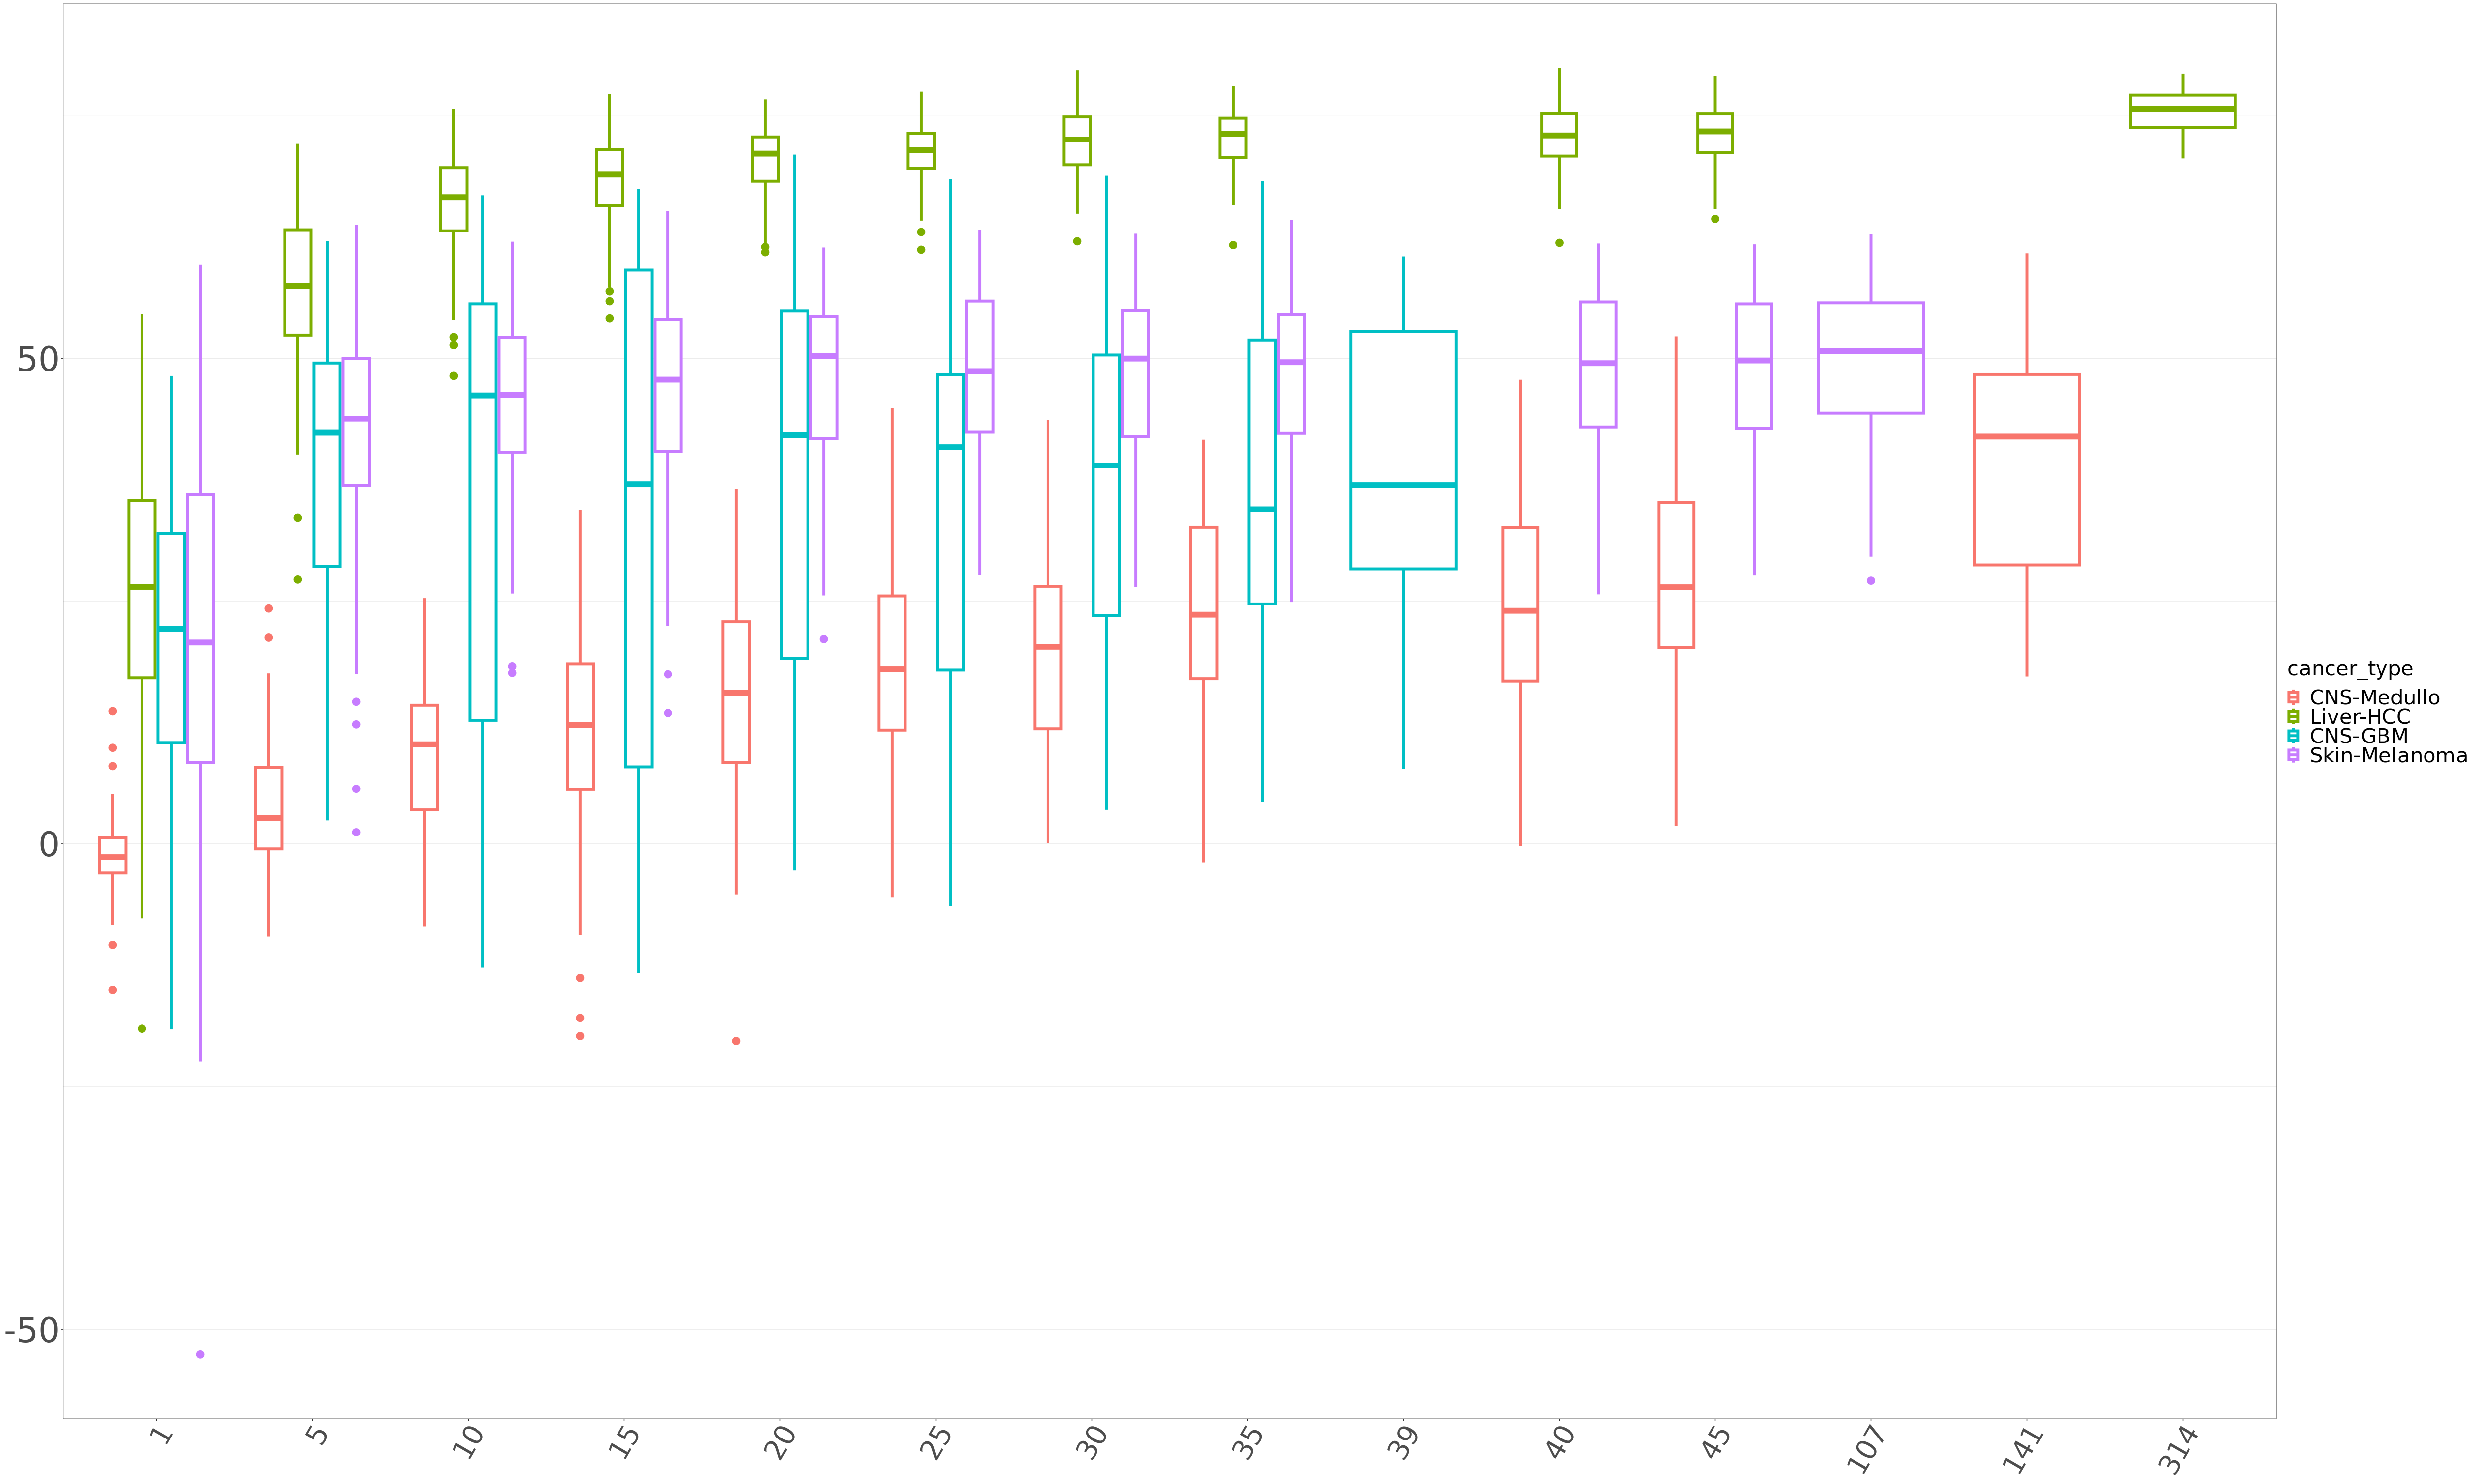

In [16]:
savepath = "../../figures"
savefile = "power_analysis.pdf"
construct_power_analysis_boxplots(df=subsampled_mutation_df, 
                                savefile=savefile, 
                                savepath=savepath,
                                width=60,
                                height=20)

In [17]:
construct_power_analysis_barplots <- function(df, savefile, savepath, width=9, height=7) {
  df$cancer_type <- factor(df$cancer_type, levels = c("CNS-Medullo", "Kidney-ChRCC", 
                                                      "Liver-HCC", "CNS-GBM",
                                                     "Lung-SCC", "Skin-Melanoma"))

#   p <- ggplot(df) +
#         geom_bar(aes(x = num_samples, y = n, fill = cancer_type), stat="identity", position="dodge") + 
#         theme_bw() +
#         theme(
#           axis.text.y = element_text(size = 50),
#           axis.text.x = element_text(size = 40, angle = 60, vjust = 1, hjust=1),
#           strip.text.x = element_blank(),
#           axis.title.x = element_blank(),
#           axis.title.y = element_blank(),
#           legend.text = element_text(size=30),
#           legend.title=element_text(size=30),
#           panel.grid.major.x = element_blank(),
#           panel.grid.minor.x = element_blank()
#         ) +
#         scale_x_continuous(breaks=unique(df$num_samples))
  p <- ggplot(df) +
        geom_bar(aes(x = as.factor(num_samples), y = n, fill = cancer_type), stat="identity", position="dodge") + 
        theme_bw() +
        theme(
          axis.text.y = element_text(size = 50),
          axis.text.x = element_text(size = 40, angle = 60, vjust = 1, hjust=1),
          strip.text.x = element_blank(),
          axis.title.x = element_blank(),
          axis.title.y = element_blank(),
          legend.text = element_text(size=30),
          legend.title=element_text(size=30),
          panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank()
        )

  print(p)
  ggsave(paste(savepath, savefile, sep = "/"), width = width, height = height, limitsize = FALSE)
}

In [18]:
lookup_df = data.frame(cancer_type = c("CNS-Medullo", "Kidney-ChRCC", 
                                       "Liver-HCC", "CNS-GBM", 
                                       "Lung-SCC", "Skin-Melanoma"),
                       putative_coo = c("cerebellum Granule neurons SH", 
                                        "kidney ICA Y_K",
                                        "liver Hepatoblasts SH",
                                        "brain mGPC GL_Br", 
                                        "lung Basal TS", 
                                        "skin_sun_exposed Melanocyte BR"))

In [19]:
custom_order = c("CNS-Medullo", "Kidney-ChRCC", "Liver-HCC", "CNS-GBM", "Lung-SCC", "Skin-Melanoma")
df = subsampled_mutation_df %>%
  mutate(cancer_type = factor(cancer_type, levels = custom_order)) %>%
  left_join(lookup_df, by = "cancer_type") %>%
  filter(top_feature == putative_coo) %>%
  select(-putative_coo) %>% 
  group_by(num_samples, top_feature, cancer_type) %>%
  count()

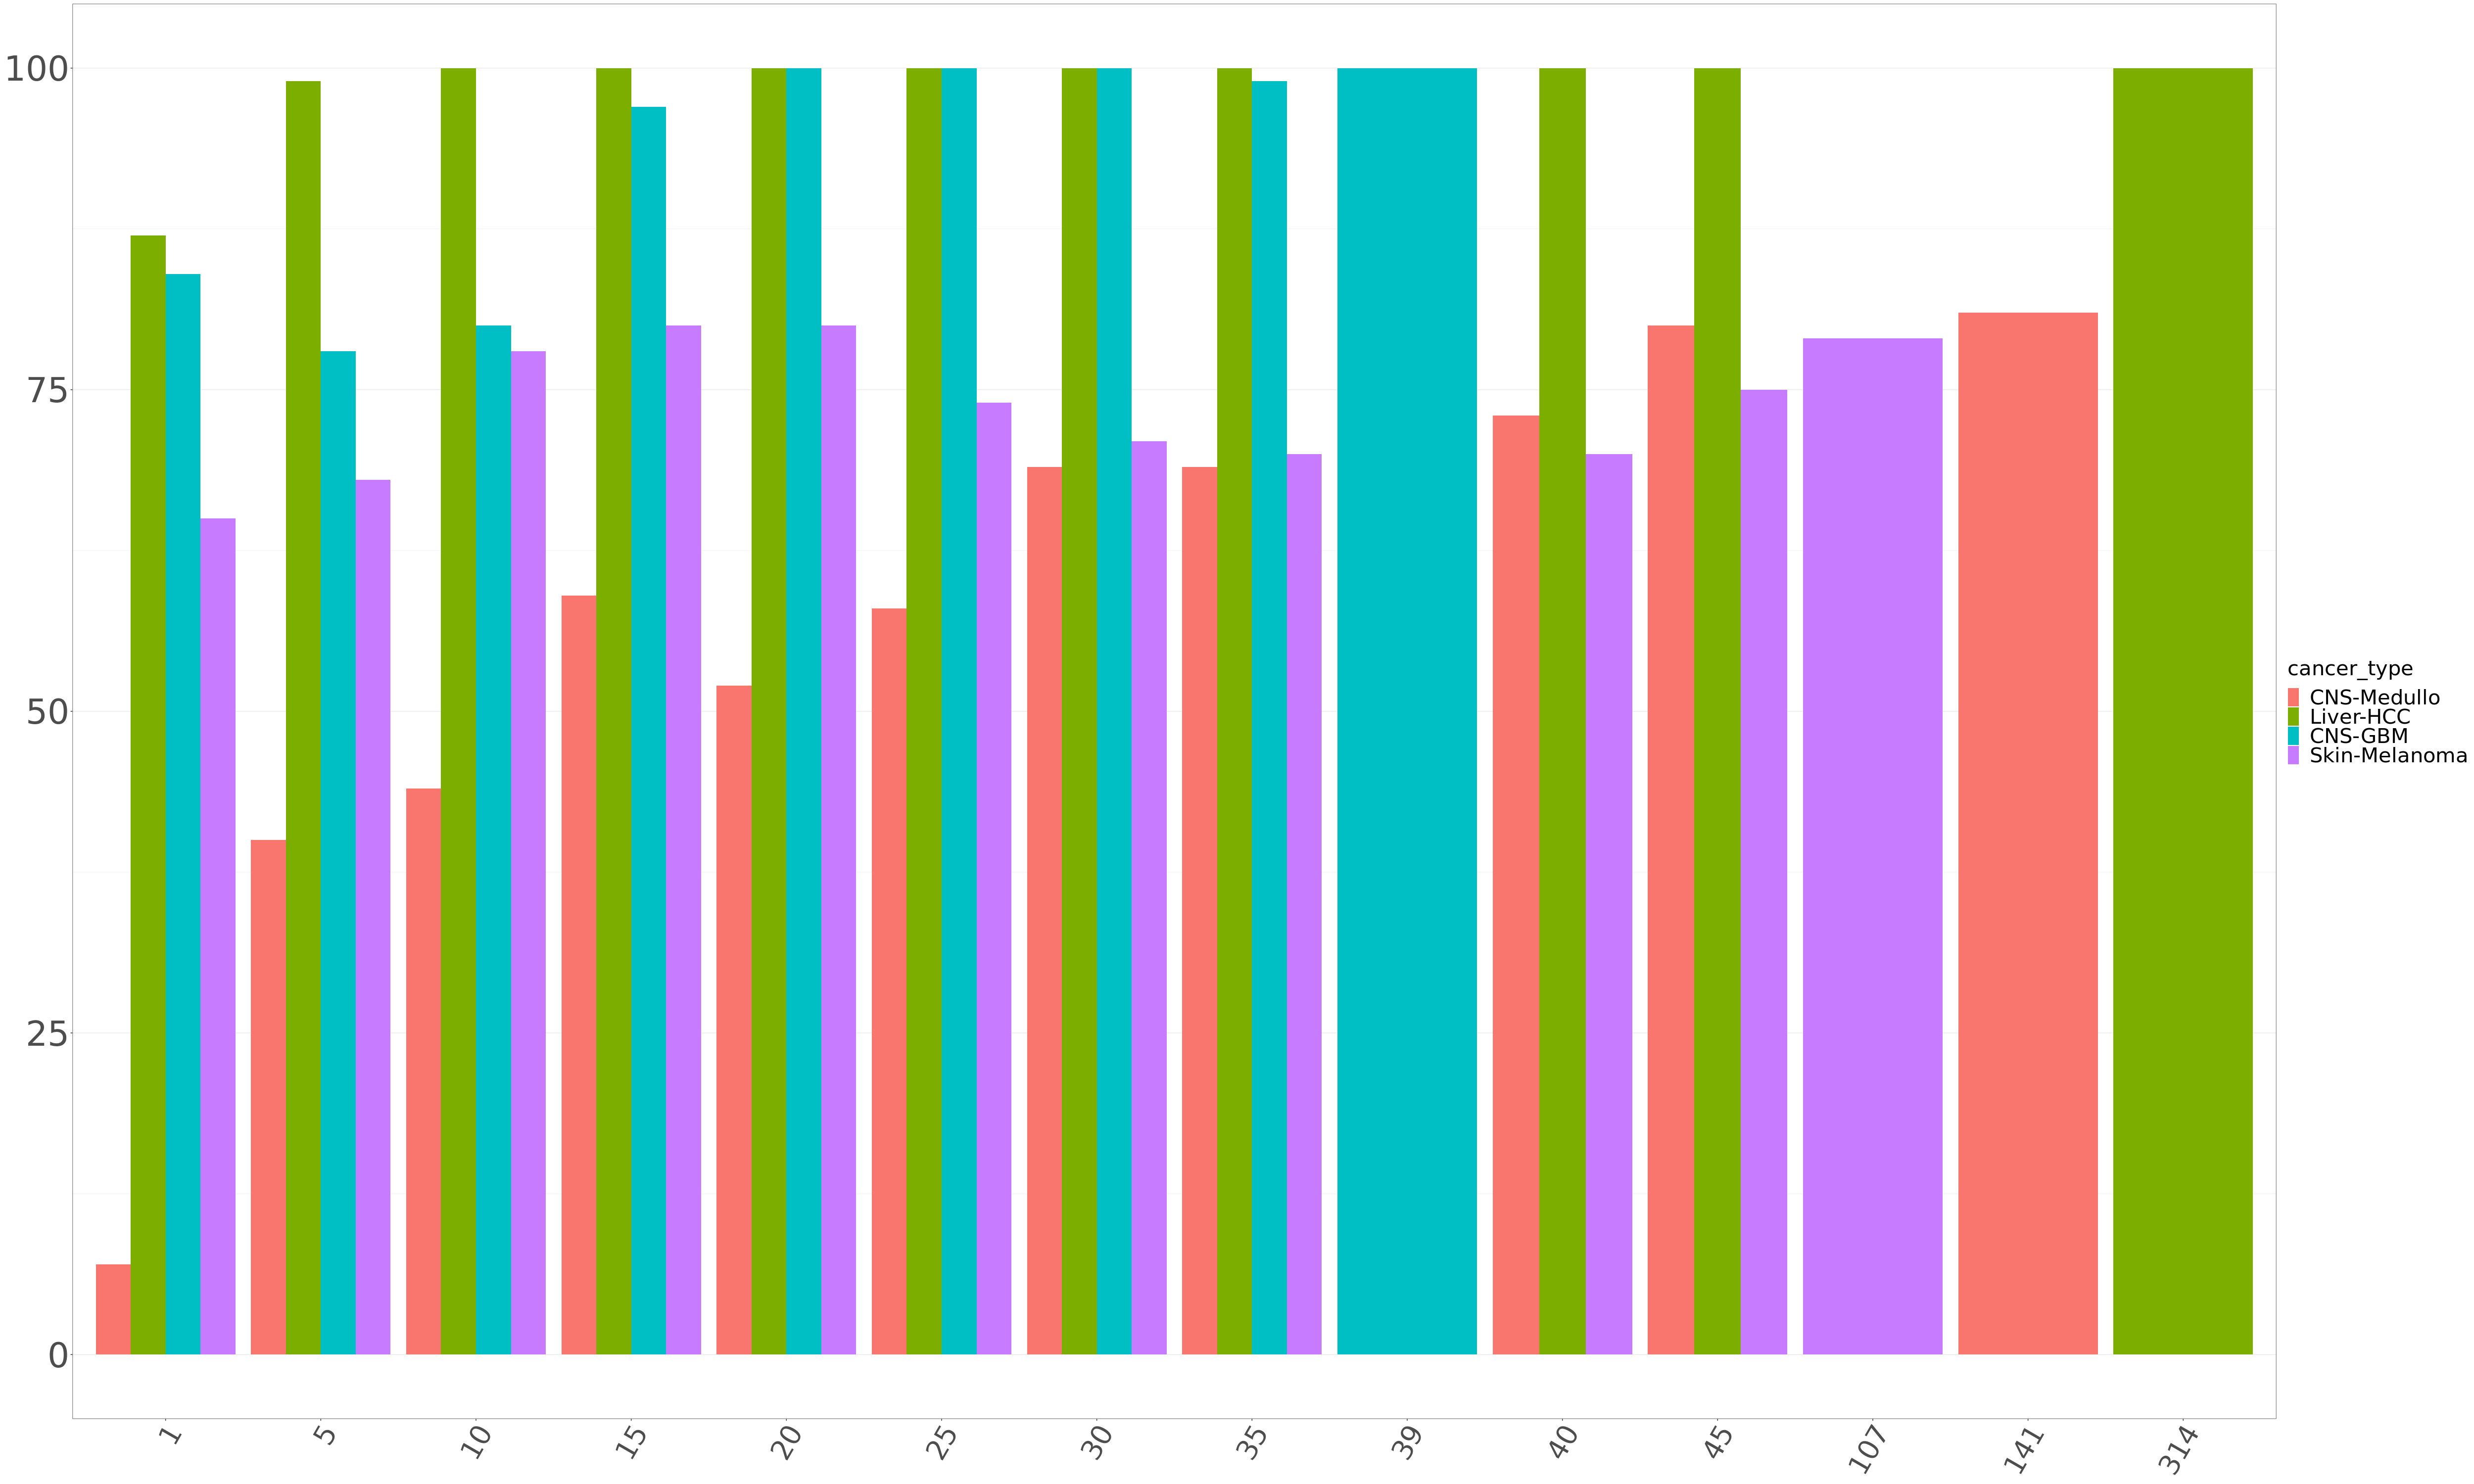

In [20]:
construct_power_analysis_barplots(df, savepath="../../figures", savefile="barplots.pdf")